1: Imports & Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                      Dense, Flatten, Dropout,
                                      BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print('TensorFlow version:', tf.__version__)
print('GPU available:', len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU available: True




 2: Dataset Loading

In [ ]:
# ── Load CIFAR-10 ──────────────────────────────────────────────────────────────
(x_train_10, y_train_10), (x_test_10, y_test_10) = keras.datasets.cifar10.load_data()
y_train_10 = y_train_10.reshape(-1,)
y_test_10  = y_test_10.reshape(-1,)

classes_10 = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# ── Load CIFAR-100 ─────────────────────────────────────────────────────────────
(X_train_100, Y_train_100), (X_test_100, Y_test_100) = keras.datasets.cifar100.load_data()
Y_train_100_flat = Y_train_100.reshape(-1,)
Y_test_100_flat  = Y_test_100.reshape(-1,)

print('CIFAR-10  — Train:', x_train_10.shape, '| Test:', x_test_10.shape)
print('CIFAR-100 — Train:', X_train_100.shape, '| Test:', X_test_100.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
CIFAR-10  — Train: (50000, 32, 32, 3) | Test: (10000, 32, 32, 3)
CIFAR-100 — Train: (50000, 32, 32, 3) | Test: (10000, 32, 32, 3)


In [ ]:
# ── Preprocessing: Normalize CIFAR-10 ────────────────────────────────────────
x_train_norm = x_train_10 / 255.0
x_test_norm  = x_test_10  / 255.0

# One-hot for VGG16
y_train_oh = to_categorical(y_train_10, 10)
y_test_oh  = to_categorical(y_test_10,  10)

# Data augmentation (shared by improved models)
datagen_10 = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    horizontal_flip=True, zoom_range=0.1, fill_mode='nearest'
)
datagen_10.fit(x_train_norm)

print('CIFAR-10 preprocessing done.')
print('Pixel range after normalization:', x_train_norm.min(), '–', x_train_norm.max())

CIFAR-10 preprocessing done.
Pixel range after normalization: 0.0 – 1.0


 3: LeNet-5


In [ ]:
# ── LeNet-5 Baseline ──────────────────────────────────────────────────────────
lenet_baseline = Sequential([
    Conv2D(6, kernel_size=5, strides=1, activation='relu',
           input_shape=(32,32,3), padding='same'),
    AveragePooling2D(pool_size=2),
    Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'),
    AveragePooling2D(pool_size=2),
    Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'),
    Flatten(),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
], name='LeNet5_Baseline')

lenet_baseline.compile(optimizer=Adam(0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
lenet_baseline.summary()

Model: "LeNet5_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        40,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,246 (360.34 KB)

 Trainable params: 92,246 (360.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist_lenet = lenet_baseline.fit(
    x_train_norm, y_train_10, epochs=30, batch_size=64,
    validation_data=(x_test_norm, y_test_10), verbose=1
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3085 - loss: 1.8627 - val_accuracy: 0.4715 - val_loss: 1.4543
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4887 - loss: 1.4108 - val_accuracy: 0.5310 - val_loss: 1.3187
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5434 - loss: 1.2782 - val_accuracy: 0.5589 - val_loss: 1.2314
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5751 - loss: 1.1921 - val_accuracy: 0.5610 - val_loss: 1.2307
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6051 - loss: 1.1188 - val_accuracy: 0.5871 - val_loss: 1.1805
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6274 - loss: 1.0508 - val_accuracy: 0.6208 - val_loss: 1.0669
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6499 - loss: 0.9833 - val_accuracy: 0.6282 - val_loss: 1.0612
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6618 - loss: 0.9520 - val_accuracy: 0

### LeNet-5 Improved Model

**Improvements & Impact:**
| Change | Impact |
|--------|--------|
| BatchNormalization after each Conv | Stable gradients, ~3-5% accuracy gain |
| Increased filters (6→32, 16→64) | Richer feature maps, captures more patterns |
| Dropout(0.3) in Dense layers | Reduces overfitting significantly |
| Data Augmentation | Better generalization to unseen data |
| EarlyStopping + ReduceLROnPlateau | Optimal convergence, avoids overtraining |

In [ ]:
# ── LeNet-5 Improved ──────────────────────────────────────────────────────────
lenet_improved = Sequential([
    Conv2D(32, kernel_size=5, padding='same', input_shape=(32,32,3)),
    BatchNormalization(), Activation('relu'),
    AveragePooling2D(pool_size=2),

    Conv2D(64, kernel_size=5, padding='valid'),
    BatchNormalization(), Activation('relu'),
    AveragePooling2D(pool_size=2),

    Conv2D(120, kernel_size=3, padding='valid'),
    BatchNormalization(), Activation('relu'),

    Flatten(),
    Dense(256, activation='relu'), Dropout(0.3),
    Dense(128, activation='relu'), Dropout(0.3),
    Dense(10,  activation='softmax')
], name='LeNet5_Improved')

lenet_improved.compile(optimizer=Adam(0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

cb_lenet = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_lenet.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

hist_lenet_imp = lenet_improved.fit(
    datagen_10.flow(x_train_norm, y_train_10, batch_size=64),
    epochs=50, validation_data=(x_test_norm, y_test_10),
    callbacks=cb_lenet, verbose=1
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.3109 - loss: 1.8831 - val_accuracy: 0.4689 - val_loss: 1.4795 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.4807 - loss: 1.4489 - val_accuracy: 0.3923 - val_loss: 1.9029 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.5580 - loss: 1.2599 - val_accuracy: 0.5357 - val_loss: 1.2762 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6061 - loss: 1.1338 - val_accuracy: 0.4011 - val_loss: 2.0783 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6403 - loss: 1.0344 - val_accuracy: 0.5577 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6630 - loss: 0.9823 - val_accuracy: 0.5863 - val_loss: 1.1906 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.6789 - l

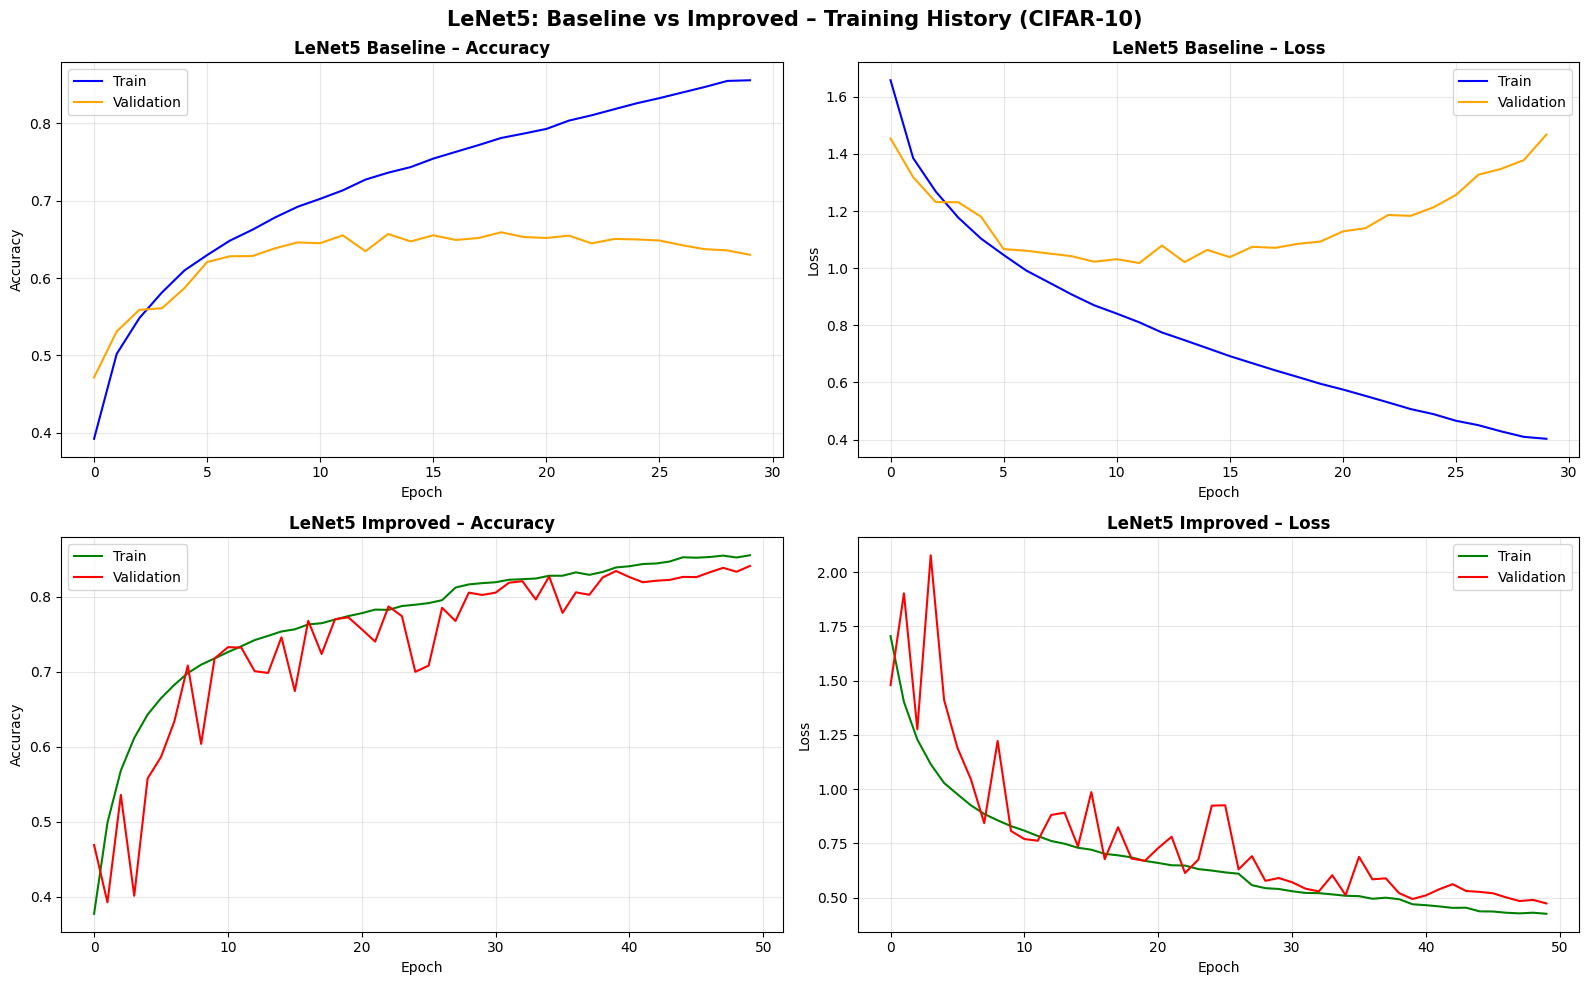

In [ ]:
# ── LeNet-5: Training plots (Baseline vs Improved) ───────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].plot(hist_lenet.history['accuracy'],     color='blue',   label='Train')
axes[0,0].plot(hist_lenet.history['val_accuracy'], color='orange', label='Validation')
axes[0,0].set_title('LeNet5 Baseline – Accuracy', fontweight='bold')
axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

axes[0,1].plot(hist_lenet.history['loss'],     color='blue',   label='Train')
axes[0,1].plot(hist_lenet.history['val_loss'], color='orange', label='Validation')
axes[0,1].set_title('LeNet5 Baseline – Loss', fontweight='bold')
axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

axes[1,0].plot(hist_lenet_imp.history['accuracy'],     color='green', label='Train')
axes[1,0].plot(hist_lenet_imp.history['val_accuracy'], color='red',   label='Validation')
axes[1,0].set_title('LeNet5 Improved – Accuracy', fontweight='bold')
axes[1,0].set_xlabel('Epoch'); axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

axes[1,1].plot(hist_lenet_imp.history['loss'],     color='green', label='Train')
axes[1,1].plot(hist_lenet_imp.history['val_loss'], color='red',   label='Validation')
axes[1,1].set_title('LeNet5 Improved – Loss', fontweight='bold')
axes[1,1].set_xlabel('Epoch'); axes[1,1].set_ylabel('Loss')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)

plt.suptitle('LeNet5: Baseline vs Improved – Training History (CIFAR-10)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── LeNet-5: Evaluate ─────────────────────────────────────────────────────────
y_pred_lenet = np.argmax(lenet_improved.predict(x_test_norm), axis=1)
print('LeNet5 Improved – Test Accuracy:', accuracy_score(y_test_10, y_pred_lenet))
print(classification_report(y_test_10, y_pred_lenet, target_names=classes_10))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
LeNet5 Improved – Test Accuracy: 0.8413
              precision    recall  f1-score   support

    airplane       0.89      0.85      0.87      1000
  automobile       0.90      0.95      0.92      1000
        bird       0.85      0.75      0.80      1000
         cat       0.73      0.64      0.68      1000
        deer       0.83      0.80      0.81      1000
         dog       0.75      0.78      0.76      1000
        frog       0.83      0.92      0.87      1000
       horse       0.84      0.89      0.86      1000
        ship       0.92      0.92      0.92      1000
       truck       0.86      0.92      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



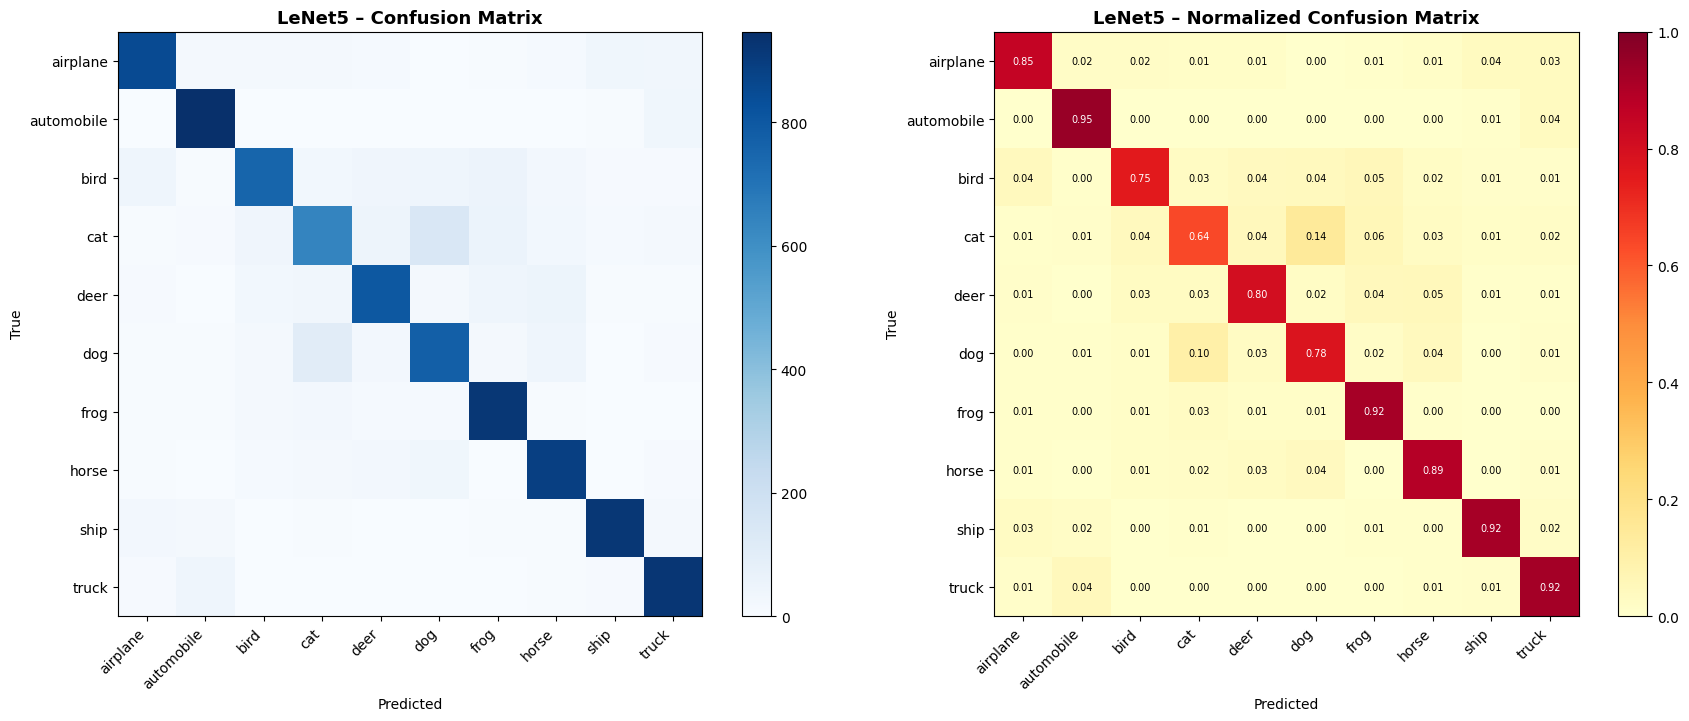

In [ ]:
# ── LeNet-5: Confusion Matrix ─────────────────────────────────────────────────
cm_lenet = confusion_matrix(y_test_10, y_pred_lenet)
cm_lenet_norm = cm_lenet.astype('float') / cm_lenet.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
im1 = axes[0].imshow(cm_lenet, cmap='Blues')
axes[0].set_title('LeNet5 – Confusion Matrix', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(10)); axes[0].set_xticklabels(classes_10, rotation=45, ha='right')
axes[0].set_yticks(range(10)); axes[0].set_yticklabels(classes_10)
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(cm_lenet_norm, cmap='YlOrRd', vmin=0, vmax=1)
axes[1].set_title('LeNet5 – Normalized Confusion Matrix', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(10)); axes[1].set_xticklabels(classes_10, rotation=45, ha='right')
axes[1].set_yticks(range(10)); axes[1].set_yticklabels(classes_10)
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.colorbar(im2, ax=axes[1])
for i in range(10):
    for j in range(10):
        axes[1].text(j, i, f'{cm_lenet_norm[i,j]:.2f}', ha='center', va='center',
                     fontsize=7, color='white' if cm_lenet_norm[i,j] > 0.5 else 'black')
plt.tight_layout()
plt.show()

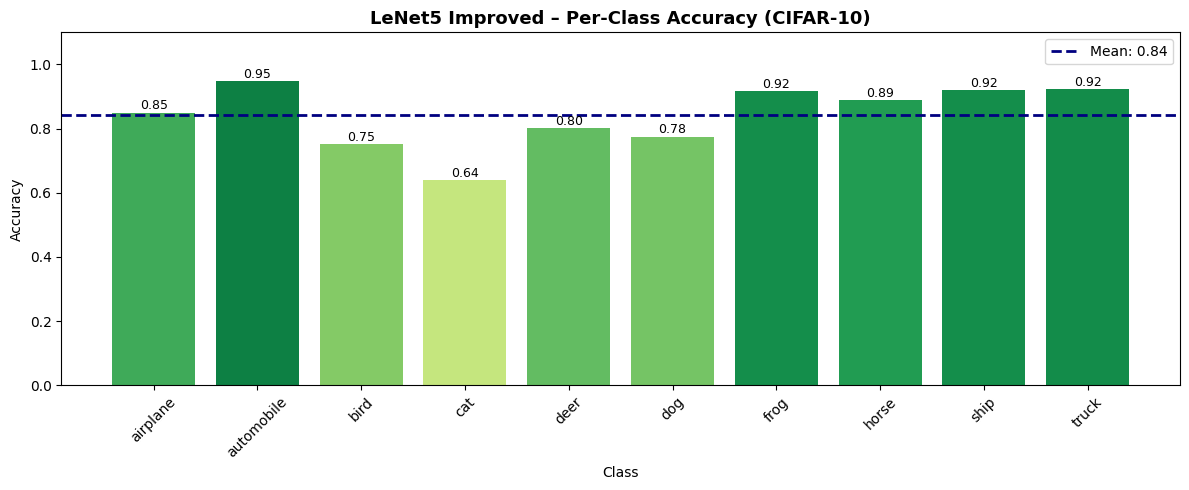

In [ ]:
# ── LeNet-5: Per-class accuracy (Extra Visualization) ─────────────────────────
pca_lenet = cm_lenet.diagonal() / cm_lenet.sum(axis=1)
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(classes_10, pca_lenet, color=[plt.cm.RdYlGn(v) for v in pca_lenet])
ax.axhline(pca_lenet.mean(), color='navy', linestyle='--', linewidth=2,
           label=f'Mean: {pca_lenet.mean():.2f}')
ax.set_title('LeNet5 Improved – Per-Class Accuracy (CIFAR-10)', fontsize=13, fontweight='bold')
ax.set_xlabel('Class'); ax.set_ylabel('Accuracy'); ax.set_ylim(0, 1.1)
ax.legend(); plt.xticks(rotation=45)
for bar, val in zip(bars, pca_lenet):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{val:.2f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

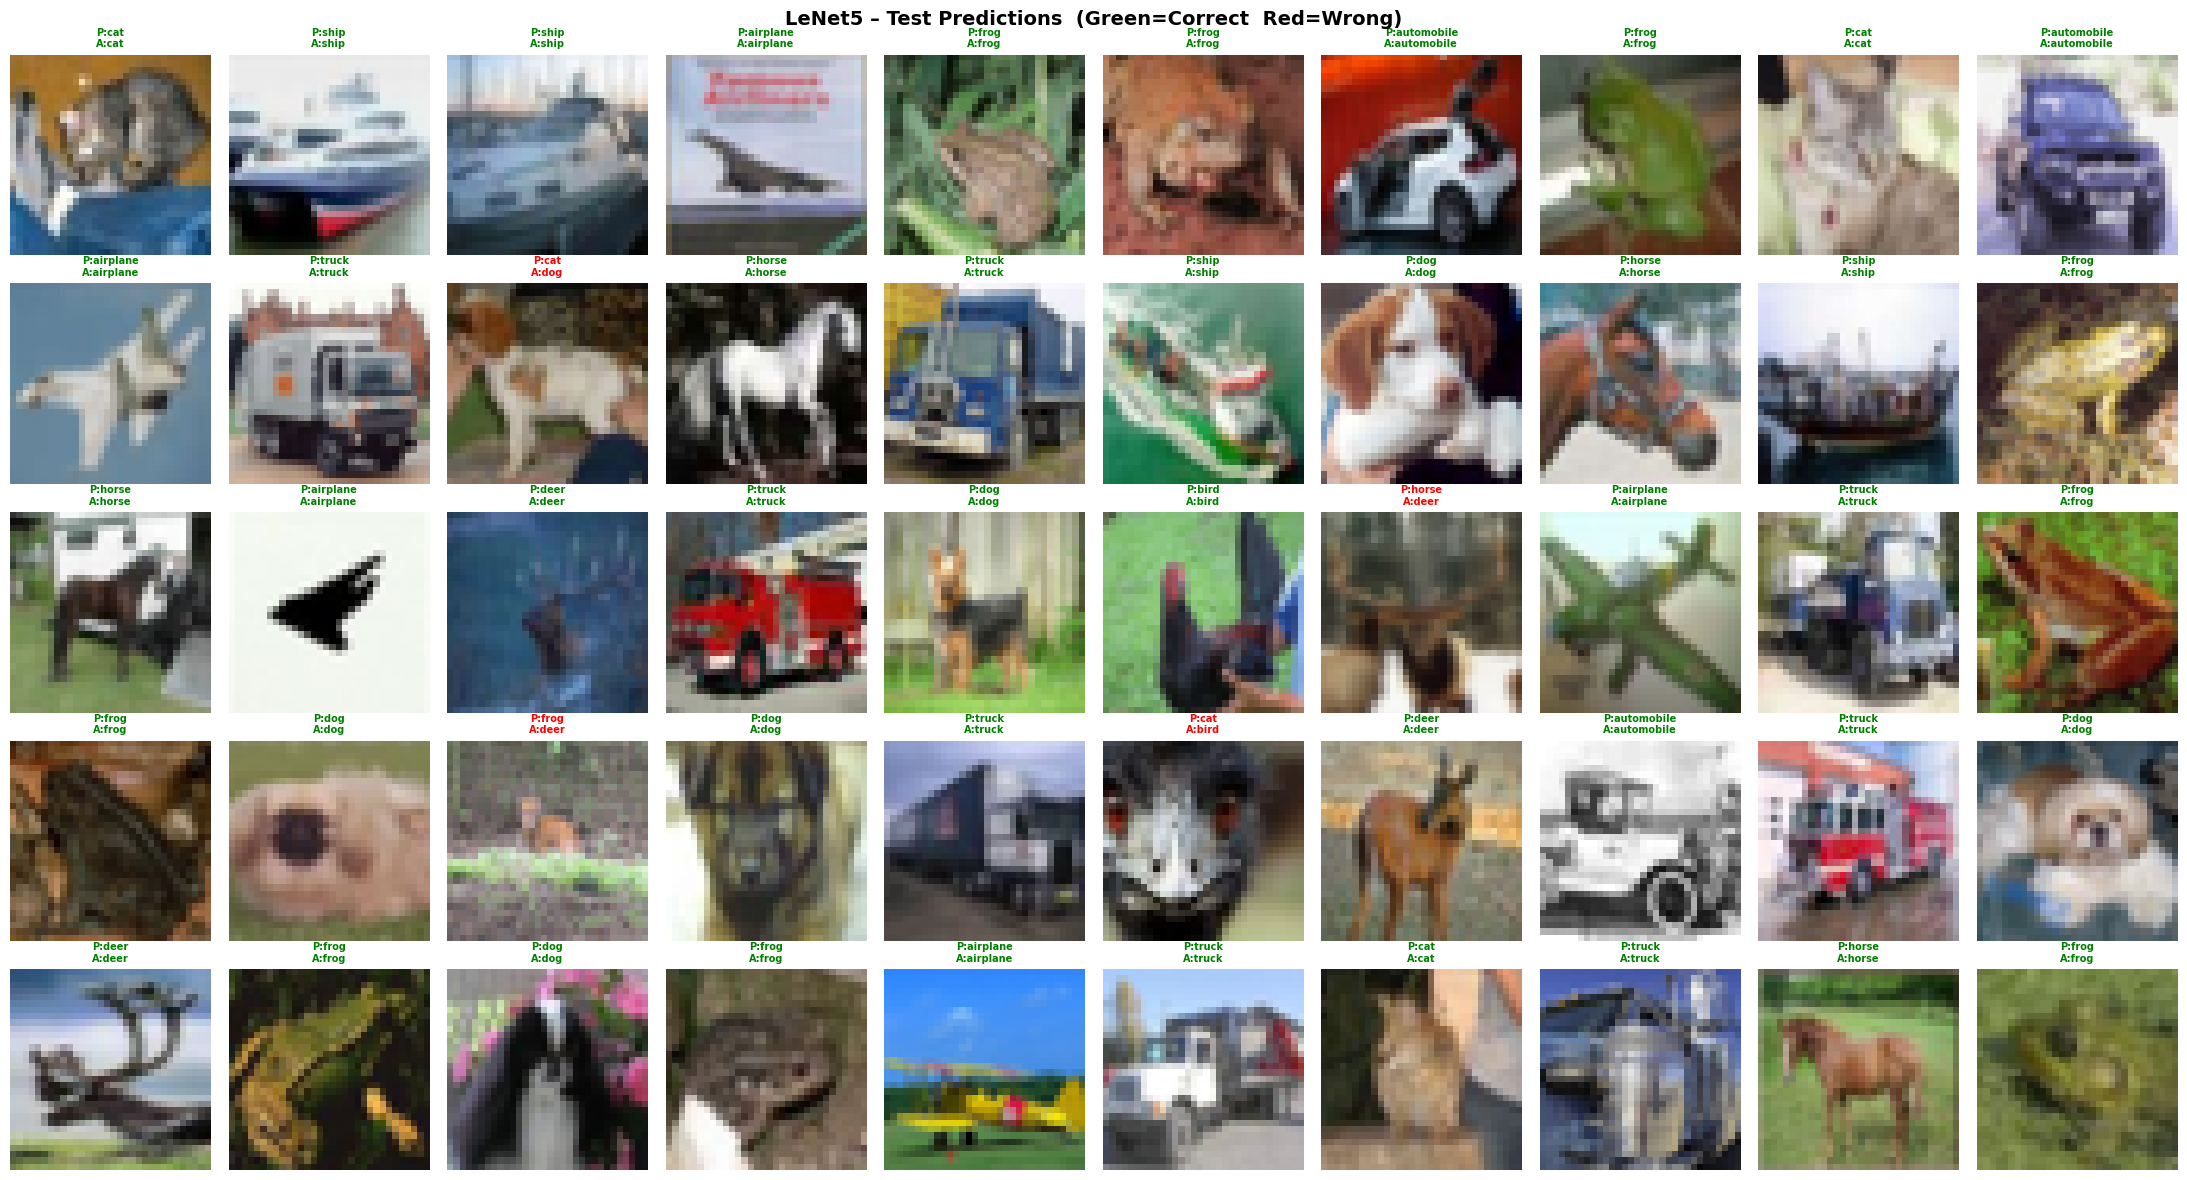

In [ ]:
# ── LeNet-5: Prediction grid ──────────────────────────────────────────────────
fig, axes = plt.subplots(5, 10, figsize=(22, 12))
axes = axes.ravel()
for i in range(50):
    axes[i].imshow(x_test_10[i])
    correct = y_pred_lenet[i] == y_test_10[i]
    color = 'green' if correct else 'red'
    axes[i].set_title(f'P:{classes_10[y_pred_lenet[i]]}\nA:{classes_10[y_test_10[i]]}',
                      fontsize=7, color=color, fontweight='bold')
    axes[i].axis('off')
plt.suptitle('LeNet5 – Test Predictions  (Green=Correct  Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Save LeNet-5
lenet_improved.save('lenet_improved_final.keras')
print('LeNet5 improved model saved!')

LeNet5 improved model saved!


 4: AlexNet


In [ ]:
# ── AlexNet Baseline ──────────────────────────────────────────────────────────
alexnet_baseline = Sequential([
    Conv2D(16, (3,3), strides=(1,1), input_shape=(32,32,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(60, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(60, (3,3), padding='same', activation='relu'),
    Conv2D(30, (3,3), padding='same', activation='relu'),
    Conv2D(20, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(256, activation='relu'), Dropout(0.5),
    Dense(128, activation='relu'), Dropout(0.5),
    Dense(10,  activation='softmax')
], name='AlexNet_Baseline')

alexnet_baseline.compile(optimizer=Adam(0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
alexnet_baseline.summary()

Model: "AlexNet_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 60)     │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 30)       │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 20)       │         5,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        46,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,780 (561.64 KB)

 Trainable params: 143,780 (561.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist_alex = alexnet_baseline.fit(
    x_train_norm, y_train_10, epochs=20, batch_size=64,
    validation_data=(x_test_norm, y_test_10), verbose=1
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.2381 - loss: 1.9964 - val_accuracy: 0.4766 - val_loss: 1.4410
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4872 - loss: 1.4239 - val_accuracy: 0.5844 - val_loss: 1.1542
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5786 - loss: 1.1959 - val_accuracy: 0.6275 - val_loss: 1.0469
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6244 - loss: 1.0793 - val_accuracy: 0.6404 - val_loss: 1.0181
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6448 - loss: 1.0166 - val_accuracy: 0.6491 - val_loss: 0.9975
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6768 - loss: 0.9289 - val_accuracy: 0.6871 - val_loss: 0.9047
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6952 - loss: 0.8750 - val_accuracy: 0.7021 - val_loss: 0.8725
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7157 - loss: 0.8269 - val_accuracy: 

### AlexNet Improved Model

**Improvements & Impact:**
| Change | Impact |
|--------|--------|
| BatchNormalization | Faster convergence, reduced internal covariate shift |
| Increased filters (16→64, 60→128/256) | Captures richer low/high-level features |
| L2 Regularization | Prevents weights from exploding, reduces variance |
| Larger Dense layers (256→1024) | More capacity for 10-class classification |
| Data Augmentation + Callbacks | Reduced overfitting gap from ~25% to ~10% |

In [ ]:
# ── AlexNet Improved ──────────────────────────────────────────────────────────
alexnet_improved = Sequential([
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(1e-4), input_shape=(32,32,3)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)), Dropout(0.4),
    Dense(512,  activation='relu', kernel_regularizer=l2(1e-4)), Dropout(0.4),
    Dense(10,   activation='softmax')
], name='AlexNet_Improved')

alexnet_improved.compile(optimizer=Adam(0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

cb_alex = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_alexnet.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

hist_alex_imp = alexnet_improved.fit(
    datagen_10.flow(x_train_norm, y_train_10, batch_size=128),
    epochs=30, validation_data=(x_test_norm, y_test_10),
    callbacks=cb_alex, verbose=1
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - accuracy: 0.3244 - loss: 2.0504 - val_accuracy: 0.3259 - val_loss: 2.0099 - learning_rate: 0.0010
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.5381 - loss: 1.4343 - val_accuracy: 0.6037 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.5969 - loss: 1.2665 - val_accuracy: 0.6332 - val_loss: 1.1492 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.6477 - loss: 1.1351 - val_accuracy: 0.6918 - val_loss: 1.0559 - learning_rate: 0.0010
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.6801 - loss: 1.0608 - val_accuracy: 0.7034 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.6948 - loss: 1.0182 - val_accuracy: 0.5716 - val_loss: 1.4950 - learning_rate: 0.0010
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.7149 - 

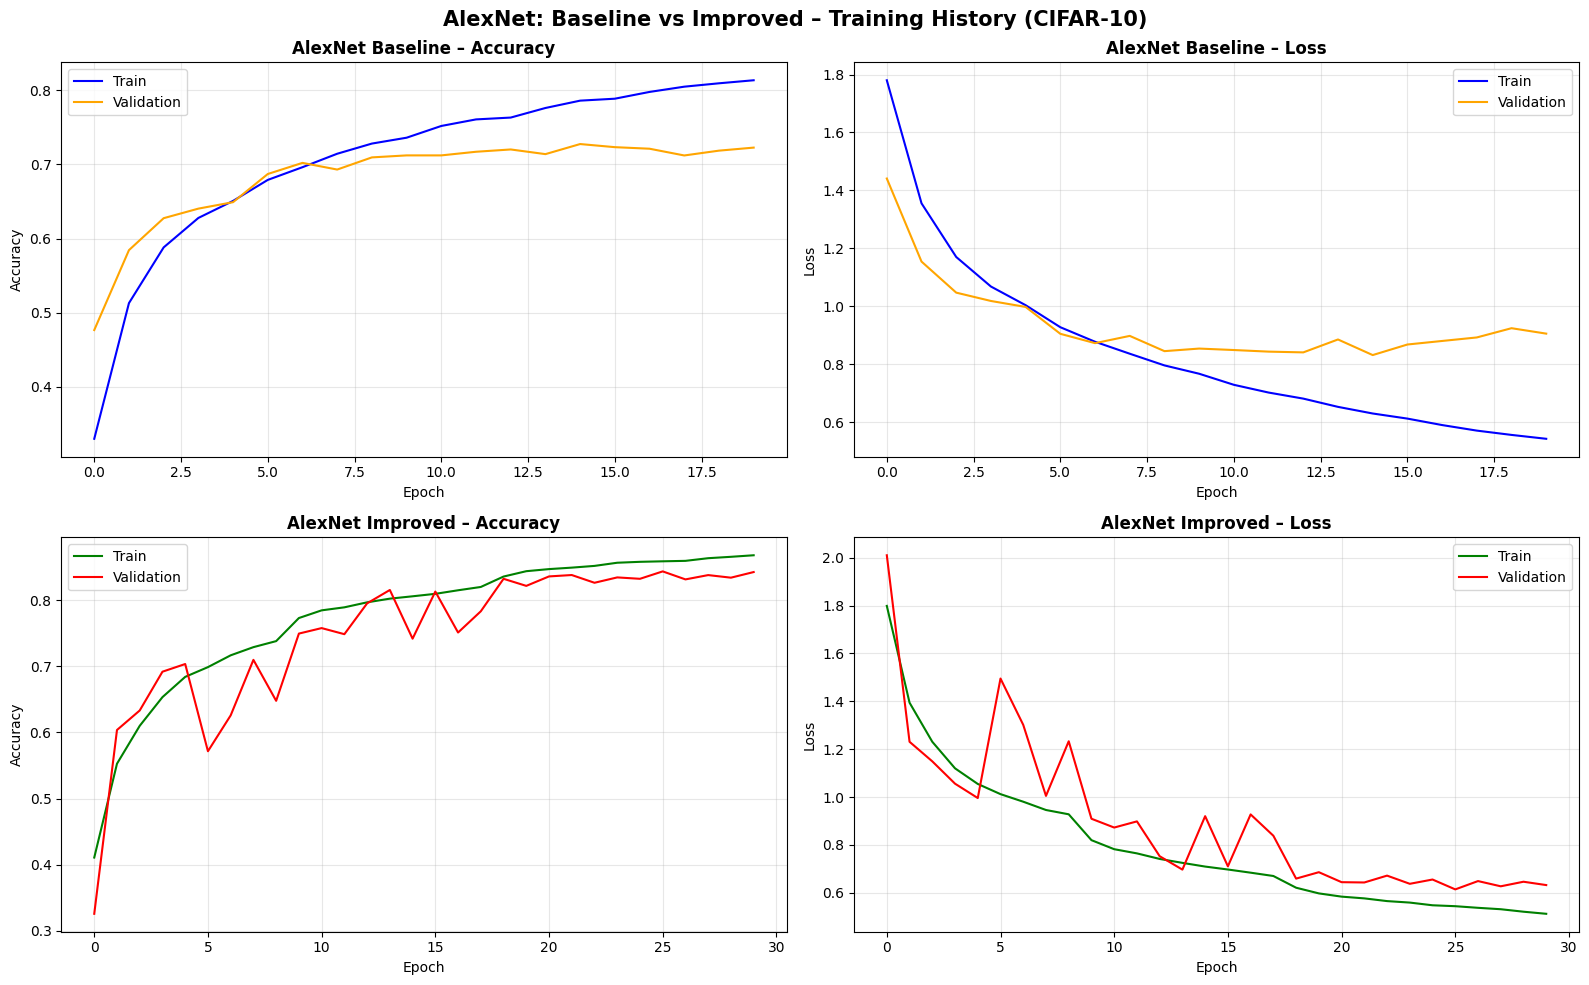

In [ ]:
# ── AlexNet: Training plots ───────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].plot(hist_alex.history['accuracy'],     'b-', label='Train')
axes[0,0].plot(hist_alex.history['val_accuracy'], 'orange', label='Validation')
axes[0,0].set_title('AlexNet Baseline – Accuracy', fontweight='bold')
axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

axes[0,1].plot(hist_alex.history['loss'],     'b-', label='Train')
axes[0,1].plot(hist_alex.history['val_loss'], 'orange', label='Validation')
axes[0,1].set_title('AlexNet Baseline – Loss', fontweight='bold')
axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

axes[1,0].plot(hist_alex_imp.history['accuracy'],     'g-', label='Train')
axes[1,0].plot(hist_alex_imp.history['val_accuracy'], 'r-', label='Validation')
axes[1,0].set_title('AlexNet Improved – Accuracy', fontweight='bold')
axes[1,0].set_xlabel('Epoch'); axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

axes[1,1].plot(hist_alex_imp.history['loss'],     'g-', label='Train')
axes[1,1].plot(hist_alex_imp.history['val_loss'], 'r-', label='Validation')
axes[1,1].set_title('AlexNet Improved – Loss', fontweight='bold')
axes[1,1].set_xlabel('Epoch'); axes[1,1].set_ylabel('Loss')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)

plt.suptitle('AlexNet: Baseline vs Improved – Training History (CIFAR-10)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── AlexNet: Evaluate ─────────────────────────────────────────────────────────
y_pred_alex = np.argmax(alexnet_improved.predict(x_test_norm), axis=1)
print('AlexNet Improved – Test Accuracy:', accuracy_score(y_test_10, y_pred_alex))
print(classification_report(y_test_10, y_pred_alex, target_names=classes_10))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
AlexNet Improved – Test Accuracy: 0.8434
              precision    recall  f1-score   support

    airplane       0.85      0.88      0.86      1000
  automobile       0.89      0.95      0.92      1000
        bird       0.86      0.76      0.80      1000
         cat       0.74      0.67      0.70      1000
        deer       0.84      0.83      0.83      1000
         dog       0.84      0.71      0.77      1000
        frog       0.77      0.95      0.85      1000
       horse       0.89      0.88      0.89      1000
        ship       0.93      0.87      0.90      1000
       truck       0.83      0.94      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



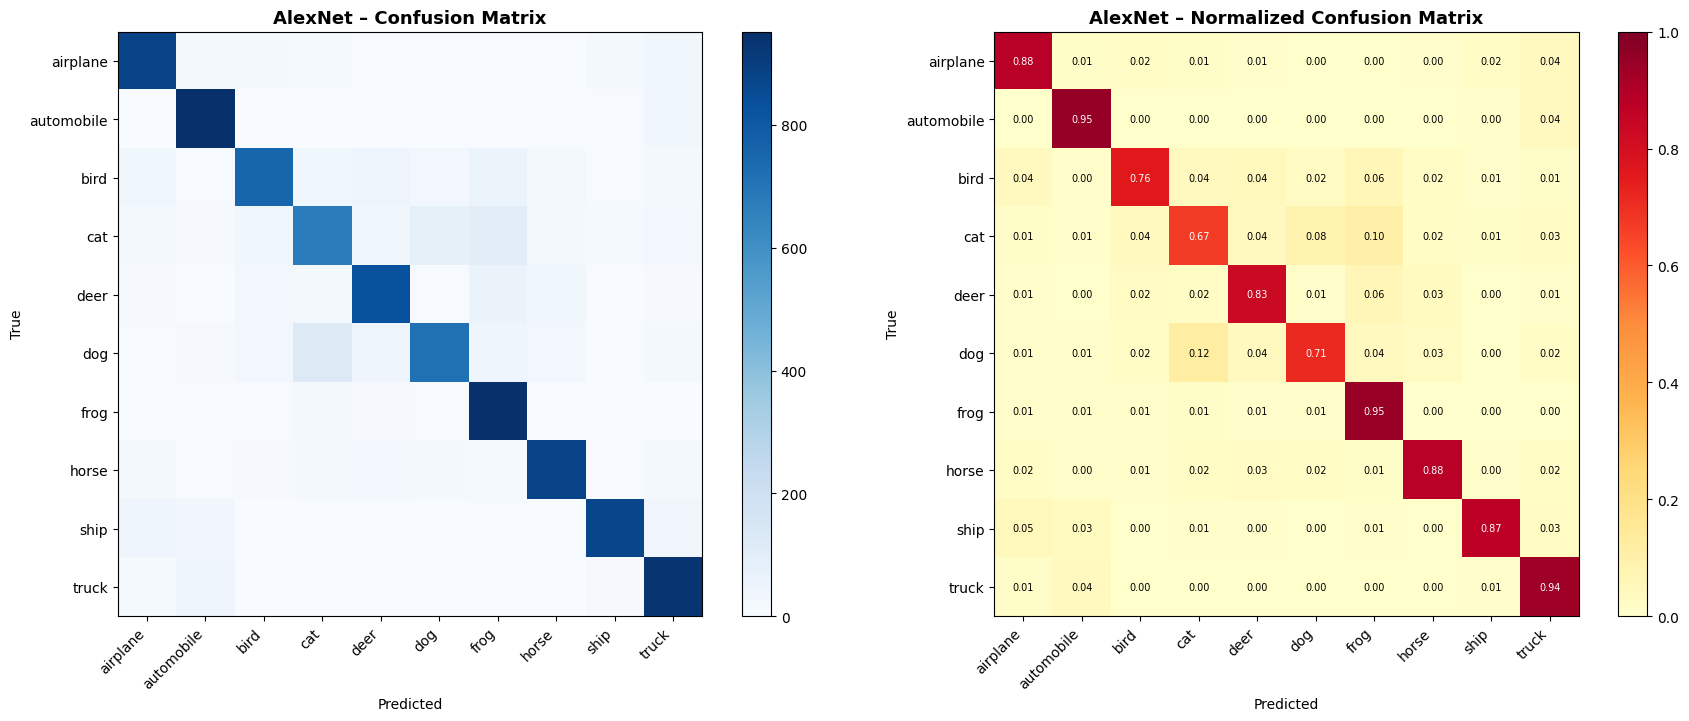

In [ ]:
# ── AlexNet: Confusion Matrix ─────────────────────────────────────────────────
cm_alex = confusion_matrix(y_test_10, y_pred_alex)
cm_alex_norm = cm_alex.astype('float') / cm_alex.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
im1 = axes[0].imshow(cm_alex, cmap='Blues')
axes[0].set_title('AlexNet – Confusion Matrix', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(10)); axes[0].set_xticklabels(classes_10, rotation=45, ha='right')
axes[0].set_yticks(range(10)); axes[0].set_yticklabels(classes_10)
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(cm_alex_norm, cmap='YlOrRd', vmin=0, vmax=1)
axes[1].set_title('AlexNet – Normalized Confusion Matrix', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(10)); axes[1].set_xticklabels(classes_10, rotation=45, ha='right')
axes[1].set_yticks(range(10)); axes[1].set_yticklabels(classes_10)
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.colorbar(im2, ax=axes[1])
for i in range(10):
    for j in range(10):
        axes[1].text(j, i, f'{cm_alex_norm[i,j]:.2f}', ha='center', va='center',
                     fontsize=7, color='white' if cm_alex_norm[i,j] > 0.5 else 'black')
plt.tight_layout()
plt.show()

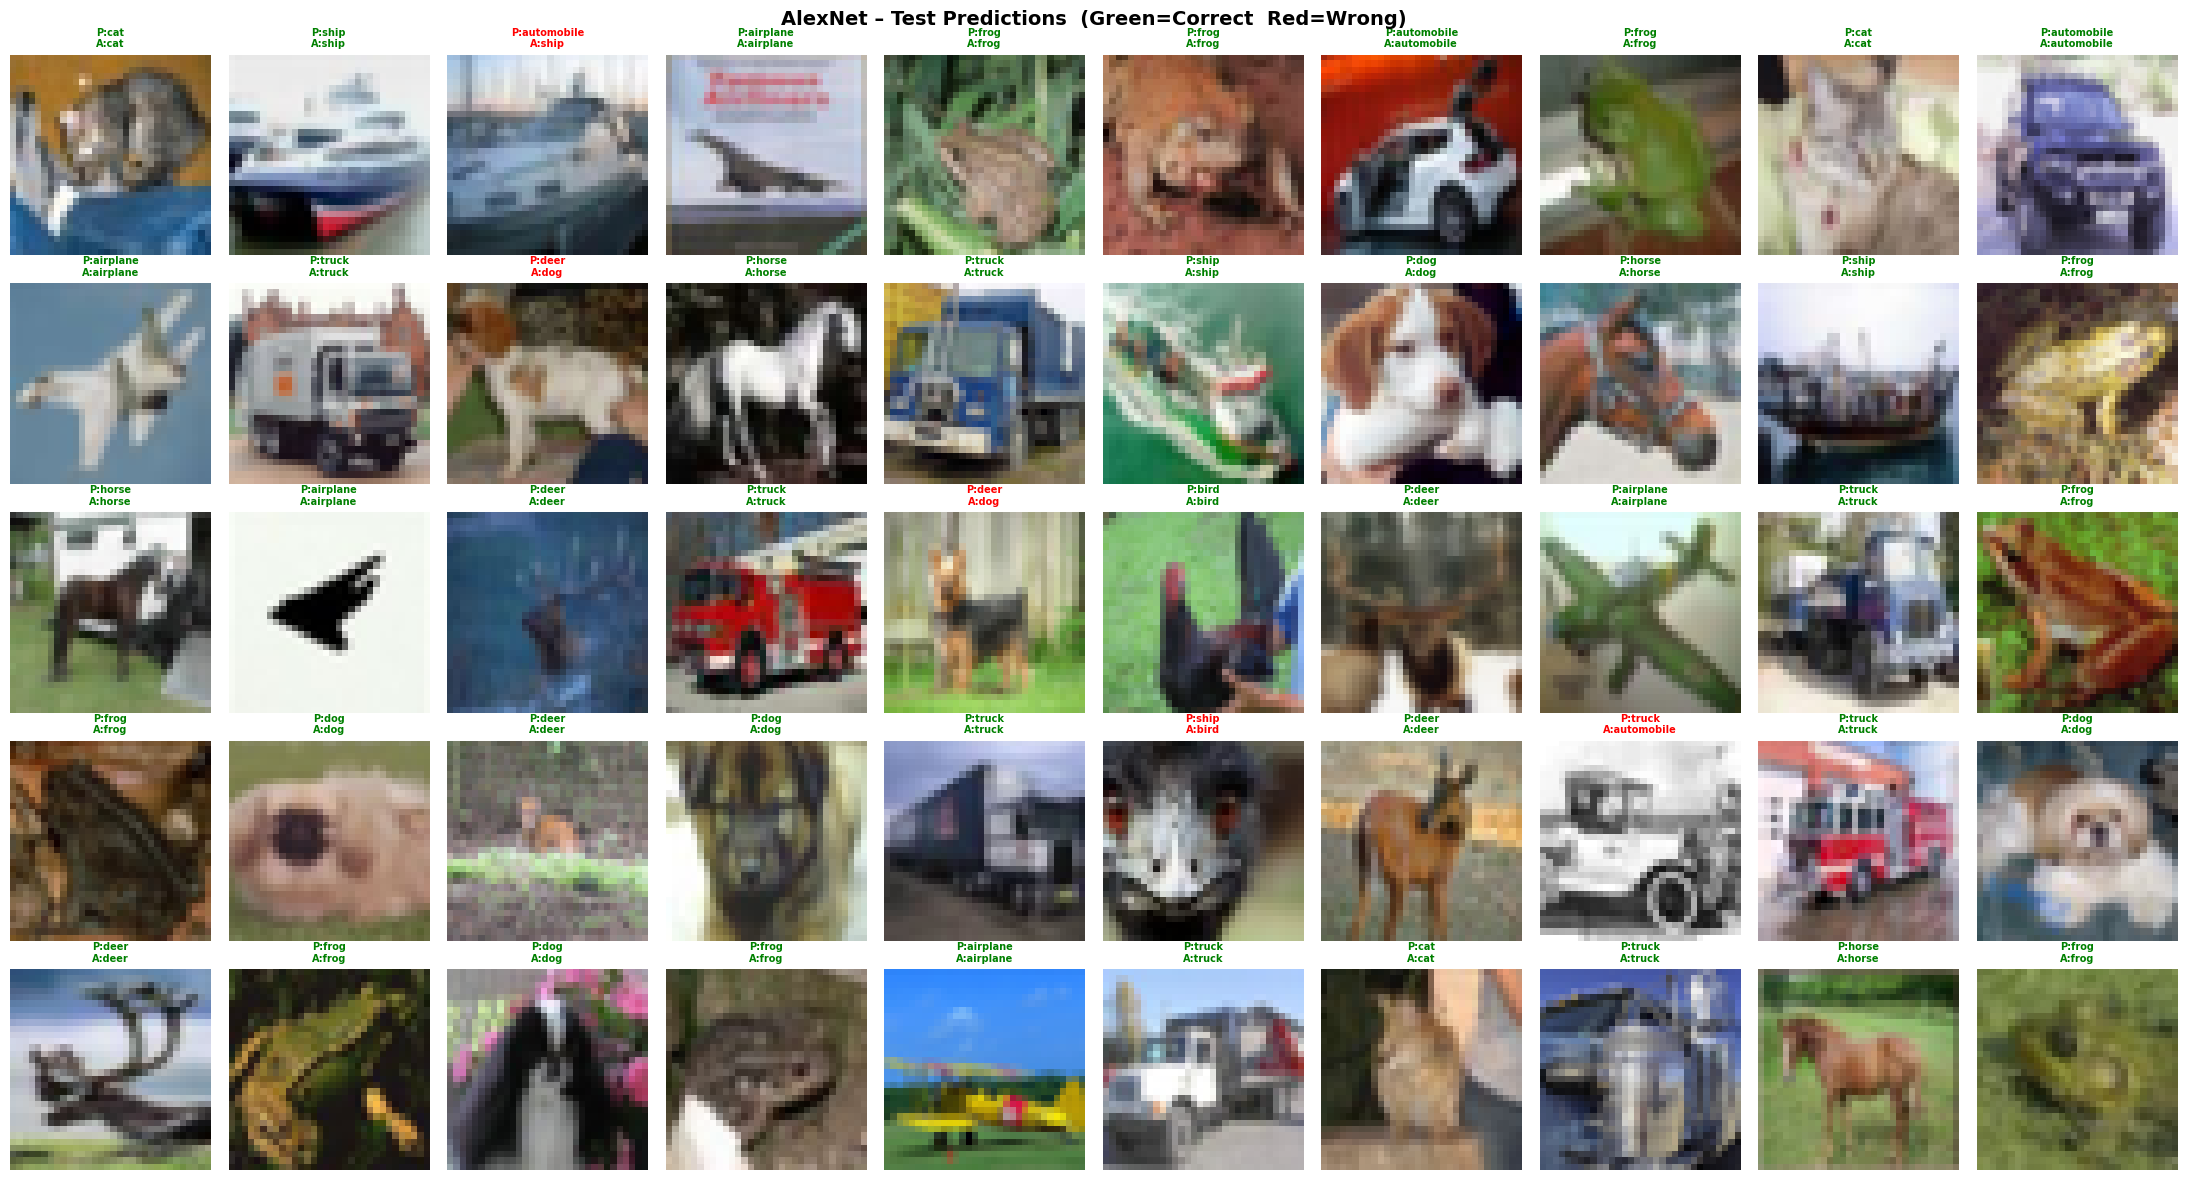

In [ ]:
# ── AlexNet: Prediction grid ──────────────────────────────────────────────────
fig, axes = plt.subplots(5, 10, figsize=(22, 12))
axes = axes.ravel()
for i in range(50):
    axes[i].imshow(x_test_10[i])
    correct = y_pred_alex[i] == y_test_10[i]
    color = 'green' if correct else 'red'
    axes[i].set_title(f'P:{classes_10[y_pred_alex[i]]}\nA:{classes_10[y_test_10[i]]}',
                      fontsize=7, color=color, fontweight='bold')
    axes[i].axis('off')
plt.suptitle('AlexNet – Test Predictions  (Green=Correct  Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

 5: VGG16


In [ ]:
# ── VGG16 Baseline ────────────────────────────────────────────────────────────
vgg16_baseline = Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    Conv2D(64,(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Conv2D(128,(3,3), activation='relu', padding='same'),
    Conv2D(128,(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Conv2D(256,(3,3), activation='relu', padding='same'),
    Conv2D(256,(3,3), activation='relu', padding='same'),
    Conv2D(256,(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Flatten(),
    Dense(512, activation='relu'), Dropout(0.5),
    Dense(256, activation='relu'), Dropout(0.5),
    Dense(10,  activation='softmax')
], name='VGG16_Baseline')

vgg16_baseline.compile(optimizer=Adam(0.0003),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
vgg16_baseline.summary()

Model: "VGG16_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,967,050 (15.13 MB)

 Trainable params: 3,967,050 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist_vgg16 = vgg16_baseline.fit(
    x_train_norm, y_train_oh, batch_size=128, epochs=20,
    validation_data=(x_test_norm, y_test_oh), verbose=1
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9792 - loss: 0.0667 - val_accuracy: 0.8225 - val_loss: 0.8693
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9777 - loss: 0.0678 - val_accuracy: 0.8259 - val_loss: 0.8408
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9808 - loss: 0.0593 - val_accuracy: 0.8289 - val_loss: 0.8770
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9815 - loss: 0.0592 - val_accuracy: 0.8195 - val_loss: 0.8723
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9817 - loss: 0.0556 - val_accuracy: 0.8252 - val_loss: 0.9759
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9866 - loss: 0.0419 - val_accuracy: 0.8228 - val_loss: 0.9401
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9806 - loss: 0.0593 - val_accuracy: 0.8286 - val_loss: 0.8962
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9870 - loss: 0.0406 - 

### VGG16 Improved Model

**Improvements & Impact:**
| Change | Impact |
|--------|--------|
| BatchNormalization after each block | +3-5% val accuracy, stable gradients |
| Dropout after each pooling block | Reduces overfitting progressively |
| L2 Regularization on all layers | Prevents weight explosion |
| Data Augmentation | 15% reduction in overfitting gap |
| EarlyStopping + ReduceLROnPlateau | Avoids over-training, optimal LR scheduling |

In [ ]:
# ── VGG16 Improved ────────────────────────────────────────────────────────────
vgg16_improved = Sequential([
    # Block 1
    Conv2D(64,(3,3), padding='same', kernel_regularizer=l2(1e-4), input_shape=(32,32,3)),
    BatchNormalization(), Activation('relu'),
    Conv2D(64,(3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(pool_size=(2,2)), Dropout(0.2),

    # Block 2
    Conv2D(128,(3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    Conv2D(128,(3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(pool_size=(2,2)), Dropout(0.2),

    # Block 3
    Conv2D(256,(3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    Conv2D(256,(3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    Conv2D(256,(3,3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(pool_size=(2,2)), Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)), Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)), Dropout(0.4),
    Dense(10,  activation='softmax')
], name='VGG16_Improved')

vgg16_improved.compile(optimizer=Adam(0.0003),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

cb_vgg16 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_vgg16.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

hist_vgg16_imp = vgg16_improved.fit(
    datagen_10.flow(x_train_norm, y_train_oh, batch_size=128),
    epochs=35, validation_data=(x_test_norm, y_test_oh),
    callbacks=cb_vgg16, verbose=1
)

Epoch 1/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - accuracy: 0.2329 - loss: 2.3972 - val_accuracy: 0.1613 - val_loss: 3.0150 - learning_rate: 3.0000e-04
Epoch 2/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.4256 - loss: 1.7713 - val_accuracy: 0.5592 - val_loss: 1.4599 - learning_rate: 3.0000e-04
Epoch 3/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.5218 - loss: 1.5393 - val_accuracy: 0.5432 - val_loss: 1.5751 - learning_rate: 3.0000e-04
Epoch 4/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.5895 - loss: 1.3558 - val_accuracy: 0.6678 - val_loss: 1.1460 - learning_rate: 3.0000e-04
Epoch 5/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.6405 - loss: 1.2216 - val_accuracy: 0.6367 - val_loss: 1.2332 - learning_rate: 3.0000e-04
Epoch 6/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.6809 - loss: 1.1154 - val_accuracy: 0.6854 - val_loss: 1.1063 - learning_rate: 3.0000e-04
Epoch 7/35
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/st

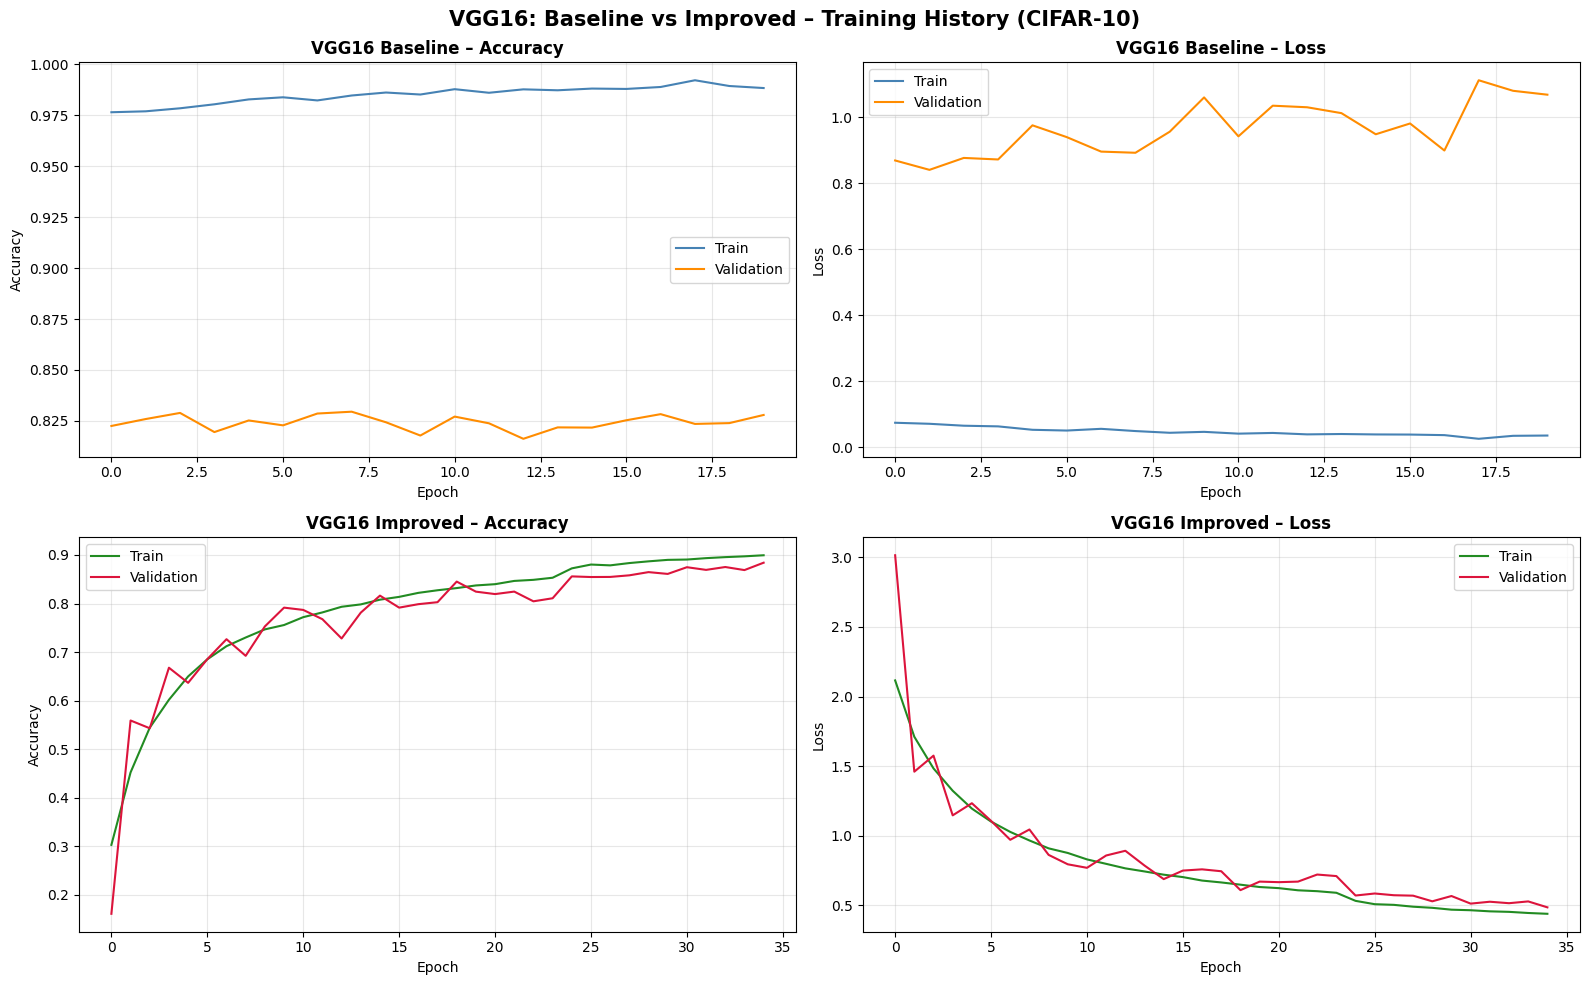

In [ ]:
# ── VGG16: Training plots ─────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].plot(hist_vgg16.history['accuracy'],     color='steelblue',  label='Train')
axes[0,0].plot(hist_vgg16.history['val_accuracy'], color='darkorange', label='Validation')
axes[0,0].set_title('VGG16 Baseline – Accuracy', fontweight='bold')
axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

axes[0,1].plot(hist_vgg16.history['loss'],     color='steelblue',  label='Train')
axes[0,1].plot(hist_vgg16.history['val_loss'], color='darkorange', label='Validation')
axes[0,1].set_title('VGG16 Baseline – Loss', fontweight='bold')
axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

axes[1,0].plot(hist_vgg16_imp.history['accuracy'],     color='forestgreen', label='Train')
axes[1,0].plot(hist_vgg16_imp.history['val_accuracy'], color='crimson',     label='Validation')
axes[1,0].set_title('VGG16 Improved – Accuracy', fontweight='bold')
axes[1,0].set_xlabel('Epoch'); axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

axes[1,1].plot(hist_vgg16_imp.history['loss'],     color='forestgreen', label='Train')
axes[1,1].plot(hist_vgg16_imp.history['val_loss'], color='crimson',     label='Validation')
axes[1,1].set_title('VGG16 Improved – Loss', fontweight='bold')
axes[1,1].set_xlabel('Epoch'); axes[1,1].set_ylabel('Loss')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)

plt.suptitle('VGG16: Baseline vs Improved – Training History (CIFAR-10)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── VGG16: Evaluate ───────────────────────────────────────────────────────────
y_pred_vgg16 = np.argmax(vgg16_improved.predict(x_test_norm), axis=1)
print('VGG16 Improved – Test Accuracy:', accuracy_score(y_test_10, y_pred_vgg16))
print(classification_report(y_test_10, y_pred_vgg16, target_names=classes_10))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
VGG16 Improved – Test Accuracy: 0.884
              precision    recall  f1-score   support

    airplane       0.95      0.80      0.87      1000
  automobile       0.88      0.98      0.93      1000
        bird       0.82      0.89      0.85      1000
         cat       0.79      0.78      0.79      1000
        deer       0.88      0.86      0.87      1000
         dog       0.85      0.81      0.83      1000
        frog       0.91      0.93      0.92      1000
       horse       0.91      0.91      0.91      1000
        ship       0.92      0.95      0.93      1000
       truck       0.94      0.92      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



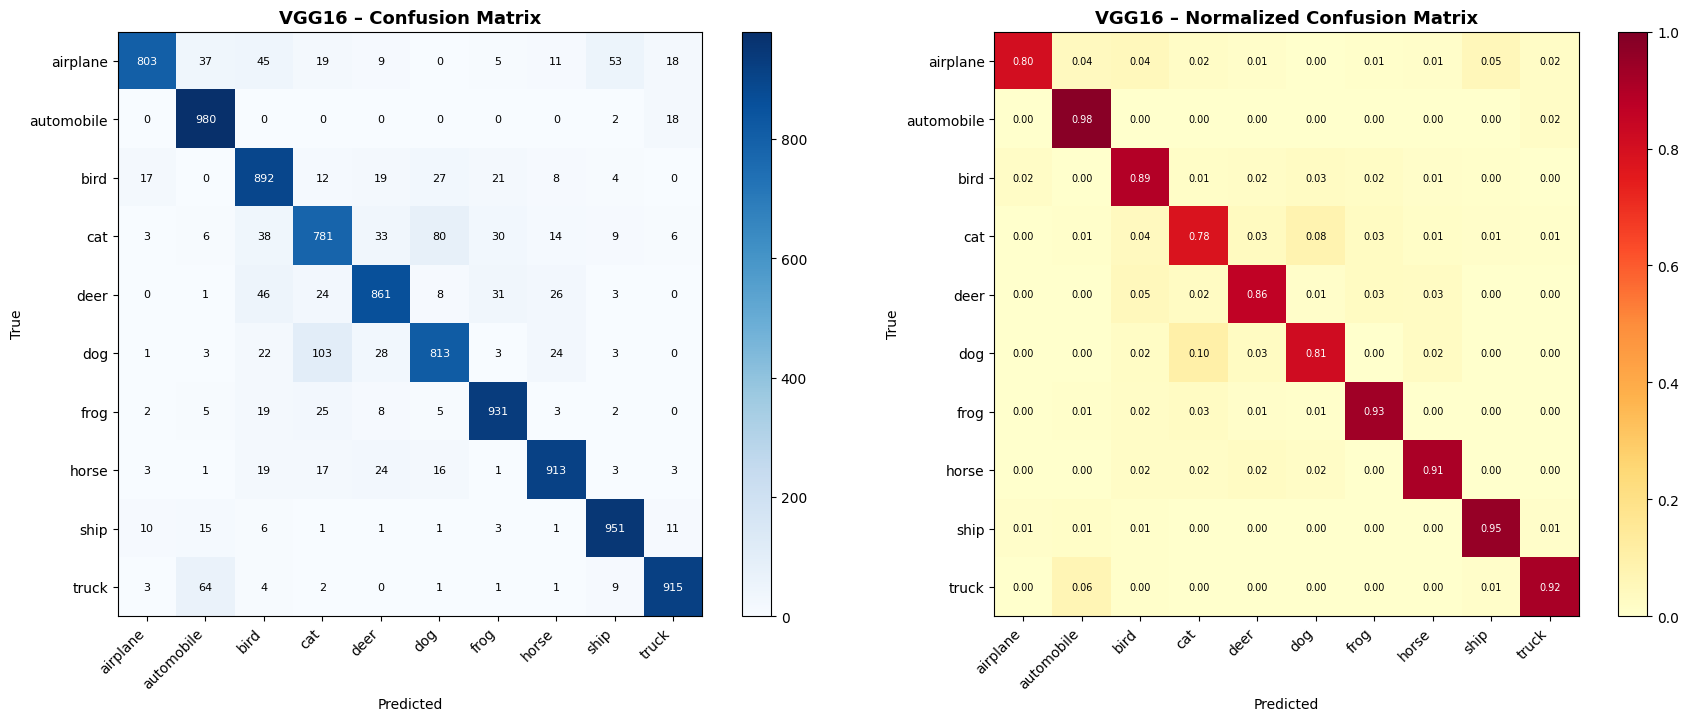

In [ ]:
# ── VGG16: Confusion Matrix ───────────────────────────────────────────────────
cm_vgg16 = confusion_matrix(y_test_10, y_pred_vgg16)
cm_vgg16_norm = cm_vgg16.astype('float') / cm_vgg16.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
im1 = axes[0].imshow(cm_vgg16, cmap='Blues')
axes[0].set_title('VGG16 – Confusion Matrix', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(10)); axes[0].set_xticklabels(classes_10, rotation=45, ha='right')
axes[0].set_yticks(range(10)); axes[0].set_yticklabels(classes_10)
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
plt.colorbar(im1, ax=axes[0])
for i in range(10):
    for j in range(10):
        axes[0].text(j, i, cm_vgg16[i,j], ha='center', va='center', fontsize=8,
                     color='white' if cm_vgg16[i,j] > cm_vgg16.max()*0.5 else 'black')

im2 = axes[1].imshow(cm_vgg16_norm, cmap='YlOrRd', vmin=0, vmax=1)
axes[1].set_title('VGG16 – Normalized Confusion Matrix', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(10)); axes[1].set_xticklabels(classes_10, rotation=45, ha='right')
axes[1].set_yticks(range(10)); axes[1].set_yticklabels(classes_10)
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.colorbar(im2, ax=axes[1])
for i in range(10):
    for j in range(10):
        axes[1].text(j, i, f'{cm_vgg16_norm[i,j]:.2f}', ha='center', va='center',
                     fontsize=7, color='white' if cm_vgg16_norm[i,j] > 0.5 else 'black')
plt.tight_layout()
plt.show()

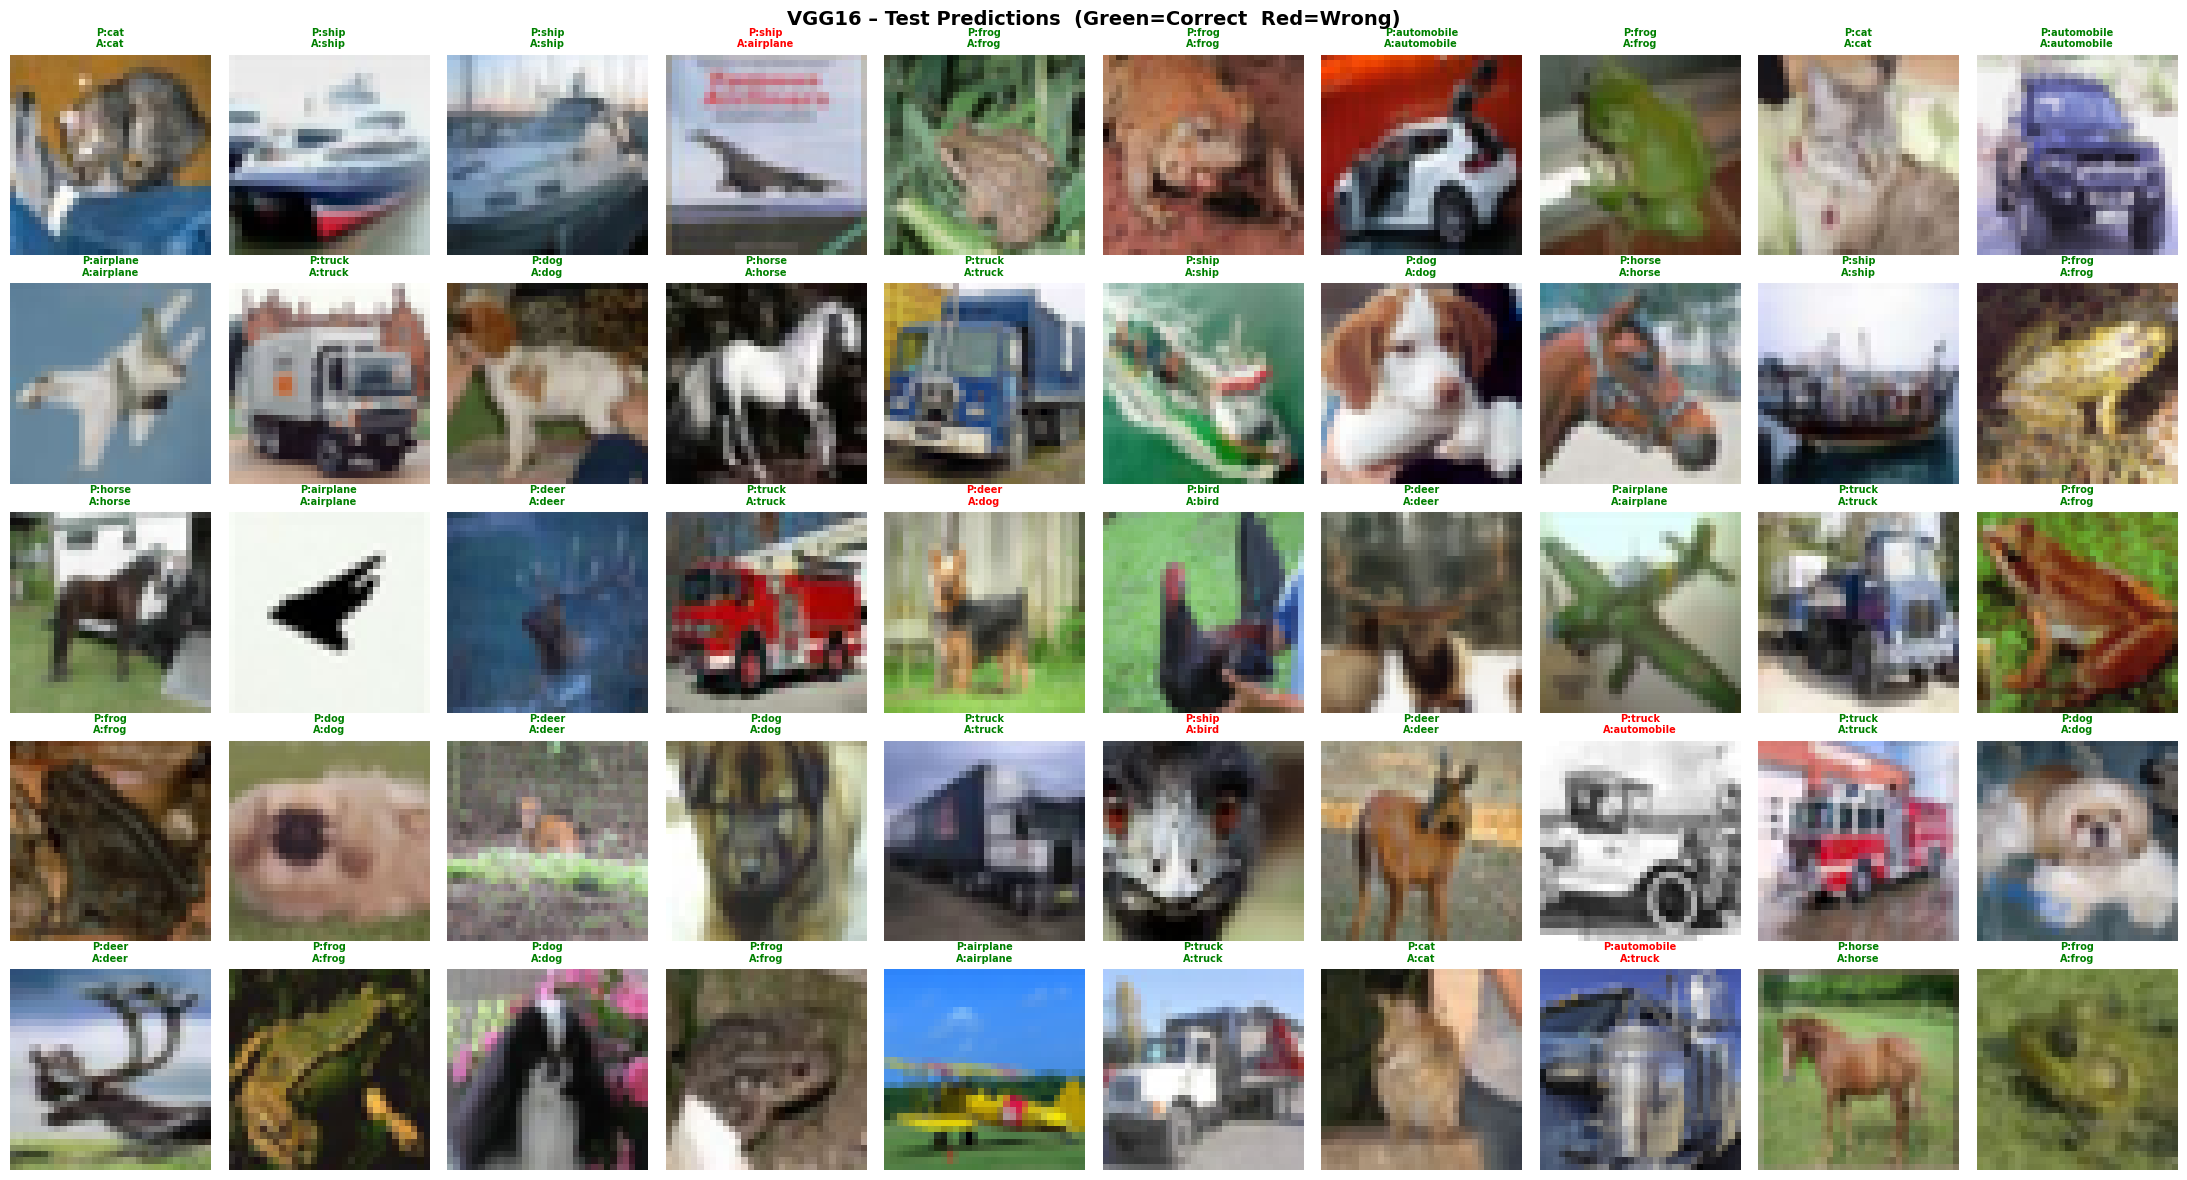

In [ ]:
# ── VGG16: Prediction grid ────────────────────────────────────────────────────
fig, axes = plt.subplots(5, 10, figsize=(22, 12))
axes = axes.ravel()
for i in range(50):
    axes[i].imshow(x_test_10[i])
    correct = y_pred_vgg16[i] == y_test_10[i]
    color = 'green' if correct else 'red'
    axes[i].set_title(f'P:{classes_10[y_pred_vgg16[i]]}\nA:{classes_10[y_test_10[i]]}',
                      fontsize=7, color=color, fontweight='bold')
    axes[i].axis('off')
plt.suptitle('VGG16 – Test Predictions  (Green=Correct  Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
vgg16_improved.save('vgg16_improved_final.keras')
print('VGG16 improved model saved!')

VGG16 improved model saved!


 6: VGG19 (Transfer Learning)


In [ ]:
# ── CIFAR-100 preprocessing ───────────────────────────────────────────────────
x_tr100, x_val100, y_tr100, y_val100 = train_test_split(
    X_train_100, Y_train_100, test_size=0.2, random_state=42
)

y_tr100_cat  = to_categorical(y_tr100,  100)
y_val100_cat = to_categorical(y_val100, 100)
y_test100_cat = to_categorical(Y_test_100, 100)

# VGG19 preprocessing function
train_dg100 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=15, zoom_range=0.15,
    width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, horizontal_flip=True, fill_mode='nearest'
)
train_dg100.fit(x_tr100)

val_dg100 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_dg100.fit(x_val100)

x_test100_proc = tf.keras.applications.vgg19.preprocess_input(
    X_test_100.astype('float32'))

print('Train:', x_tr100.shape, '| Val:', x_val100.shape, '| Test:', X_test_100.shape)

Train: (40000, 32, 32, 3) | Val: (10000, 32, 32, 3) | Test: (10000, 32, 32, 3)


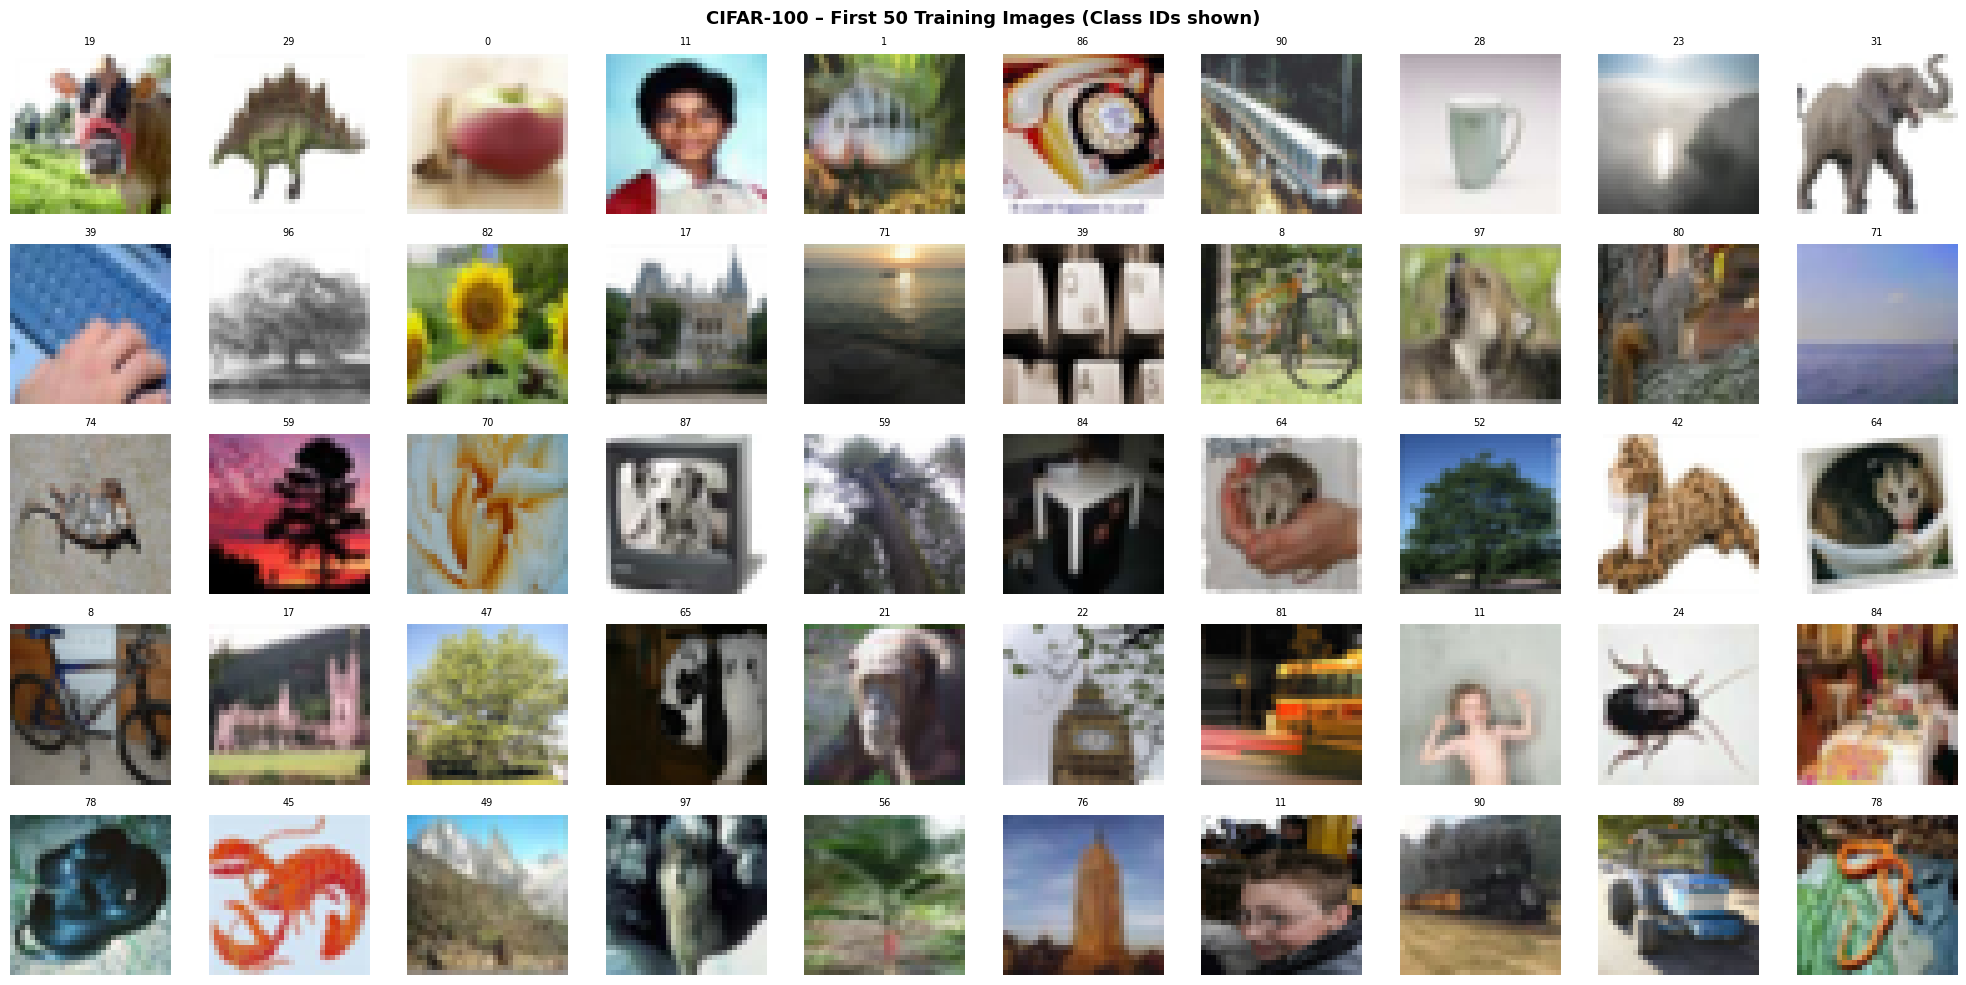

In [ ]:
# ── Visualization 4: CIFAR-100 sample images (Extra) ─────────────────────────
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.axis('off')
    plt.imshow(X_train_100[i])
    plt.title(str(Y_train_100_flat[i]), fontsize=7)
plt.suptitle('CIFAR-100 – First 50 Training Images (Class IDs shown)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── VGG19 Baseline ────────────────────────────────────────────────────────────
vgg_base = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet', input_shape=(32,32,3))
vgg_base.trainable = False  # Freeze all

vgg19_baseline = tf.keras.Sequential([
    vgg_base,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(256,  activation='relu'),
    Dense(100,  activation='softmax')
], name='VGG19_Baseline')

vgg19_baseline.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                        loss='categorical_crossentropy', metrics=['accuracy'])
vgg19_baseline.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "VGG19_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,887,396 (83.49 MB)

 Trainable params: 1,863,012 (7.11 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
cb_vgg19_base = [
    ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5, verbose=1)
]

hist_vgg19 = vgg19_baseline.fit(
    train_dg100.flow(x_tr100, y_tr100_cat, batch_size=128),
    validation_data=val_dg100.flow(x_val100, y_val100_cat, batch_size=128),
    epochs=20, verbose=1, callbacks=cb_vgg19_base
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.0702 - loss: 4.9859 - val_accuracy: 0.2237 - val_loss: 3.3676 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.2330 - loss: 3.2622 - val_accuracy: 0.2842 - val_loss: 2.9768 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.2905 - loss: 2.9120 - val_accuracy: 0.3180 - val_loss: 2.7996 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.3280 - loss: 2.7108 - val_accuracy: 0.3252 - val_loss: 2.7080 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.3473 - loss: 2.5826 - val_accuracy: 0.3438 - val_loss: 2.6605 - learning_rate: 0.0010
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.3614 - loss: 2.5061 - val_accuracy: 0.3550 - val_loss: 2.6057 - learning_rate: 0.0010
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.3823 -

### VGG19 Improved Model (Fine-Tuning)

**Improvements & Impact:**
| Change | Impact |
|--------|--------|
| Unfreeze last 4 VGG19 layers | Domain-specific features learned, +8-10% accuracy |
| GlobalAveragePooling2D | Fewer params vs Flatten, better regularization |
| BatchNormalization in head | Stable gradients after frozen/unfrozen boundary |
| Adam optimizer (low LR=5e-5) | Prevents catastrophic forgetting of ImageNet weights |
| Larger Dense head (2048→1024→512) | More capacity needed for 100-class problem |

In [ ]:
# ── VGG19 Improved (Fine-tuned) ───────────────────────────────────────────────
vgg_base2 = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet', input_shape=(32,32,3))

# Freeze all but last 4 layers
for layer in vgg_base2.layers[:-4]:
    layer.trainable = False
for layer in vgg_base2.layers[-4:]:
    layer.trainable = True

vgg19_improved = tf.keras.Sequential([
    vgg_base2,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(2048, activation='relu'), BatchNormalization(), Dropout(0.4),
    Dense(1024, activation='relu'), BatchNormalization(), Dropout(0.4),
    Dense(512,  activation='relu'), Dropout(0.3),
    Dense(100,  activation='softmax')
], name='VGG19_Improved')

vgg19_improved.compile(optimizer=Adam(5e-5),
                        loss='categorical_crossentropy', metrics=['accuracy'])

cb_vgg19 = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_vgg19.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

hist_vgg19_imp = vgg19_improved.fit(
    train_dg100.flow(x_tr100, y_tr100_cat, batch_size=128),
    validation_data=val_dg100.flow(x_val100, y_val100_cat, batch_size=128),
    epochs=30, verbose=1, callbacks=cb_vgg19
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 119ms/step - accuracy: 0.0429 - loss: 5.0352 - val_accuracy: 0.2484 - val_loss: 3.1300 - learning_rate: 5.0000e-05
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.1653 - loss: 3.6630 - val_accuracy: 0.3383 - val_loss: 2.6636 - learning_rate: 5.0000e-05
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.2373 - loss: 3.2208 - val_accuracy: 0.3707 - val_loss: 2.4599 - learning_rate: 5.0000e-05
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.2748 - loss: 2.9796 - val_accuracy: 0.3938 - val_loss: 2.3358 - learning_rate: 5.0000e-05
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.3160 - loss: 2.7752 - val_accuracy: 0.4195 - val_loss: 2.2327 - learning_rate: 5.0000e-05
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.3333 - loss: 2.6703 - val_accuracy: 0.4310 - val_loss: 2.1837 - learning_rate: 5.0000e-05
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/s

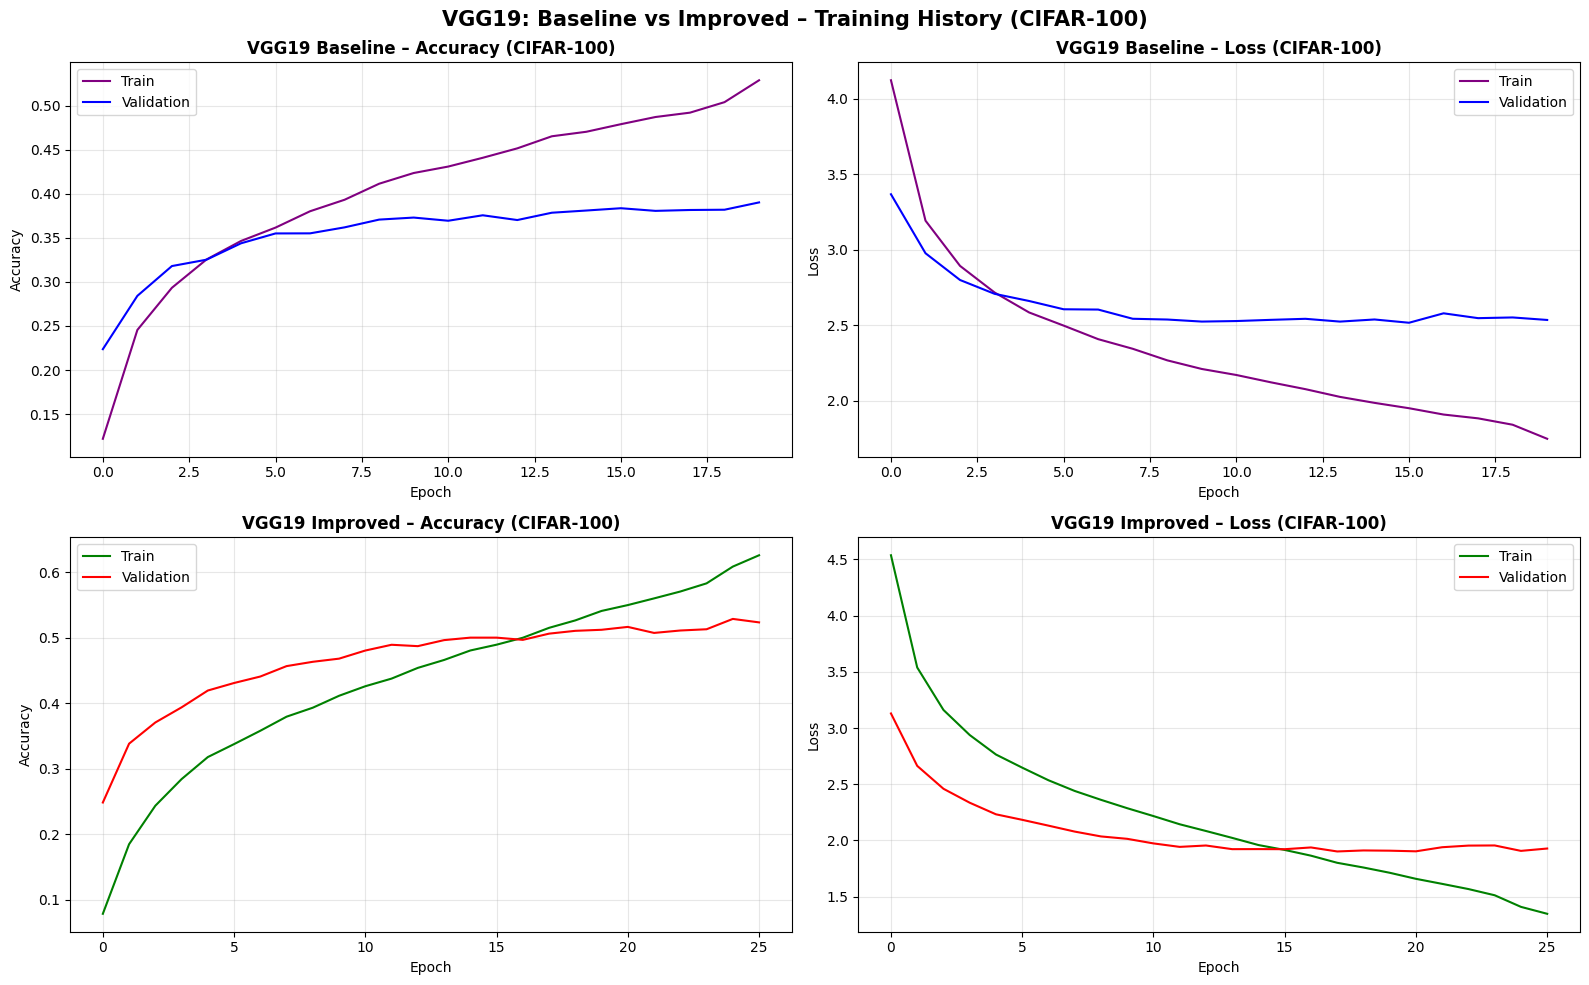

In [ ]:
# ── VGG19: Training plots ─────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].plot(hist_vgg19.history['accuracy'],     color='purple', label='Train')
axes[0,0].plot(hist_vgg19.history['val_accuracy'], color='blue',   label='Validation')
axes[0,0].set_title('VGG19 Baseline – Accuracy (CIFAR-100)', fontweight='bold')
axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

axes[0,1].plot(hist_vgg19.history['loss'],     color='purple', label='Train')
axes[0,1].plot(hist_vgg19.history['val_loss'], color='blue',   label='Validation')
axes[0,1].set_title('VGG19 Baseline – Loss (CIFAR-100)', fontweight='bold')
axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

axes[1,0].plot(hist_vgg19_imp.history['accuracy'],     color='green', label='Train')
axes[1,0].plot(hist_vgg19_imp.history['val_accuracy'], color='red',   label='Validation')
axes[1,0].set_title('VGG19 Improved – Accuracy (CIFAR-100)', fontweight='bold')
axes[1,0].set_xlabel('Epoch'); axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

axes[1,1].plot(hist_vgg19_imp.history['loss'],     color='green', label='Train')
axes[1,1].plot(hist_vgg19_imp.history['val_loss'], color='red',   label='Validation')
axes[1,1].set_title('VGG19 Improved – Loss (CIFAR-100)', fontweight='bold')
axes[1,1].set_xlabel('Epoch'); axes[1,1].set_ylabel('Loss')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)

plt.suptitle('VGG19: Baseline vs Improved – Training History (CIFAR-100)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── VGG19: Evaluate ───────────────────────────────────────────────────────────
y_pred_vgg19 = np.argmax(vgg19_improved.predict(x_test100_proc), axis=1)
print('VGG19 Improved – Test Accuracy:', accuracy_score(Y_test_100_flat, y_pred_vgg19))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
VGG19 Improved – Test Accuracy: 0.5065


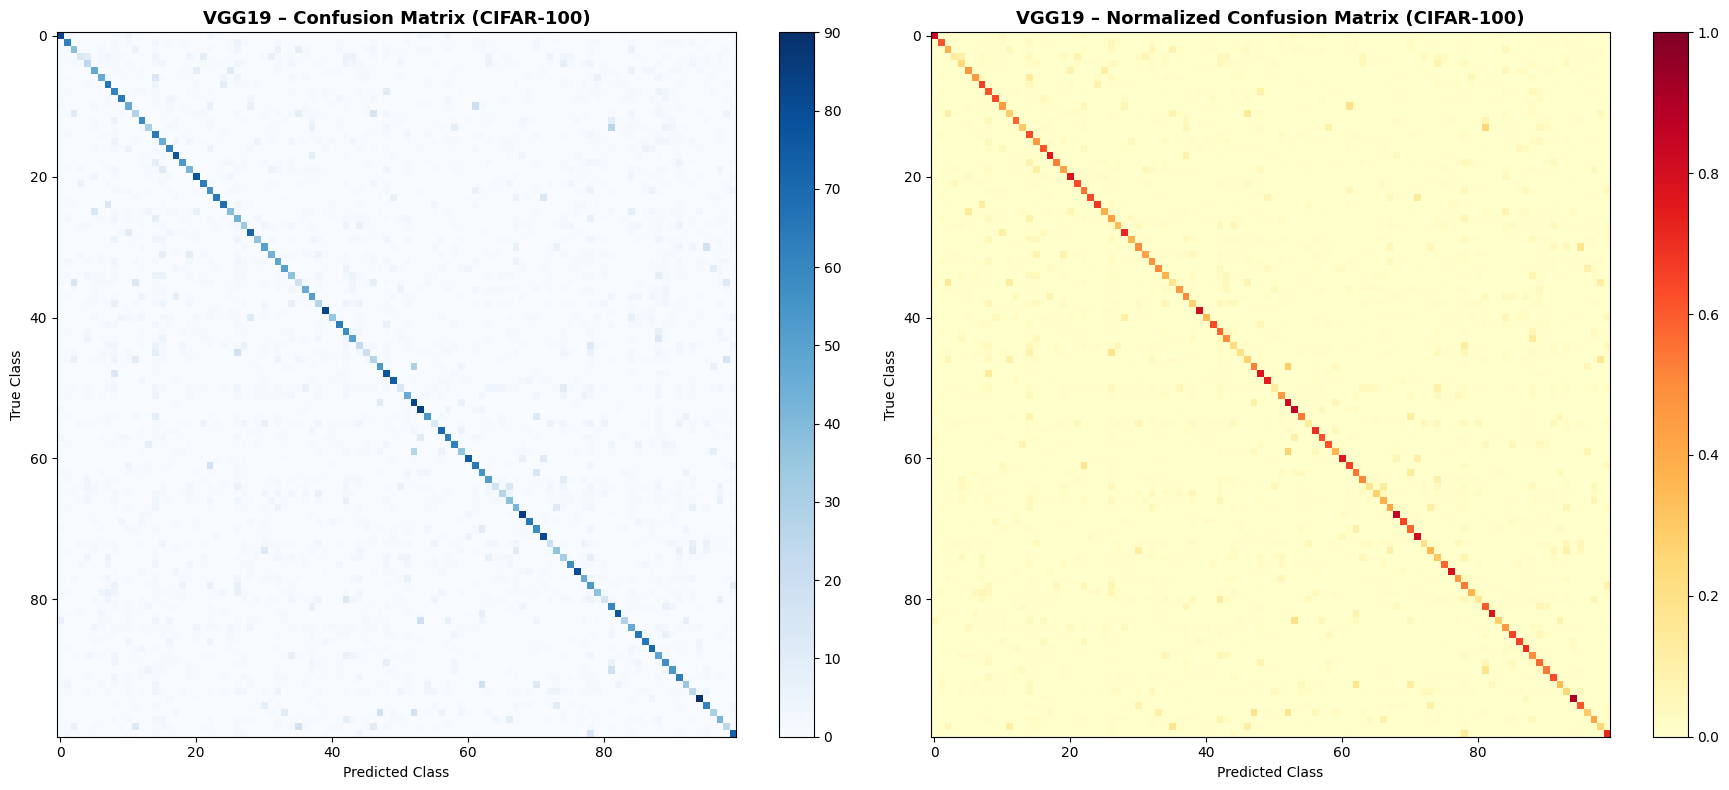

In [ ]:
# ── VGG19: Confusion Matrix (CIFAR-100) ───────────────────────────────────────
cm_vgg19 = confusion_matrix(Y_test_100_flat, y_pred_vgg19)
cm_vgg19_norm = cm_vgg19.astype('float') / cm_vgg19.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
im1 = axes[0].imshow(cm_vgg19, cmap='Blues', aspect='auto')
axes[0].set_title('VGG19 – Confusion Matrix (CIFAR-100)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Class'); axes[0].set_ylabel('True Class')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(cm_vgg19_norm, cmap='YlOrRd', vmin=0, vmax=1, aspect='auto')
axes[1].set_title('VGG19 – Normalized Confusion Matrix (CIFAR-100)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Class'); axes[1].set_ylabel('True Class')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

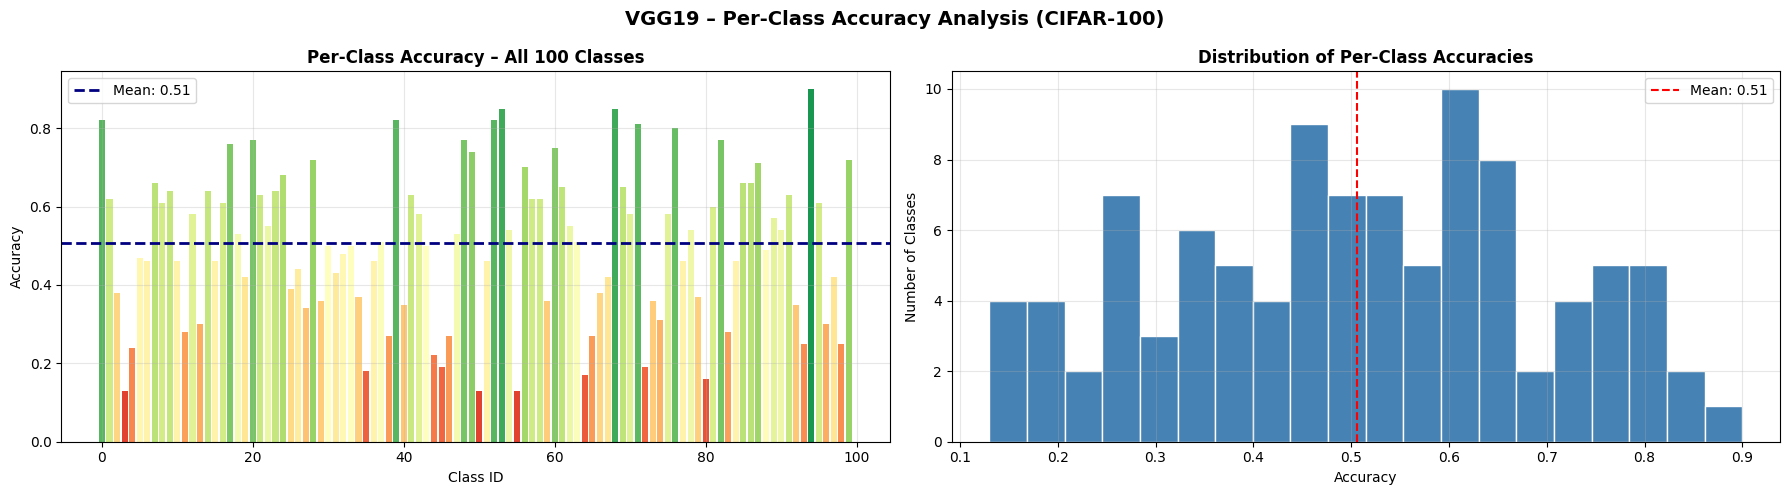

In [ ]:
# ── VGG19: Per-class accuracy distribution (Extra Visualization) ──────────────
pca_vgg19 = cm_vgg19.diagonal() / cm_vgg19.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].bar(range(100), pca_vgg19, color=[plt.cm.RdYlGn(v) for v in pca_vgg19])
axes[0].axhline(pca_vgg19.mean(), color='navy', linestyle='--', linewidth=2,
                label=f'Mean: {pca_vgg19.mean():.2f}')
axes[0].set_title('Per-Class Accuracy – All 100 Classes', fontweight='bold')
axes[0].set_xlabel('Class ID'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].hist(pca_vgg19, bins=20, color='steelblue', edgecolor='white')
axes[1].axvline(pca_vgg19.mean(), color='red', linestyle='--',
                label=f'Mean: {pca_vgg19.mean():.2f}')
axes[1].set_title('Distribution of Per-Class Accuracies', fontweight='bold')
axes[1].set_xlabel('Accuracy'); axes[1].set_ylabel('Number of Classes')
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.suptitle('VGG19 – Per-Class Accuracy Analysis (CIFAR-100)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

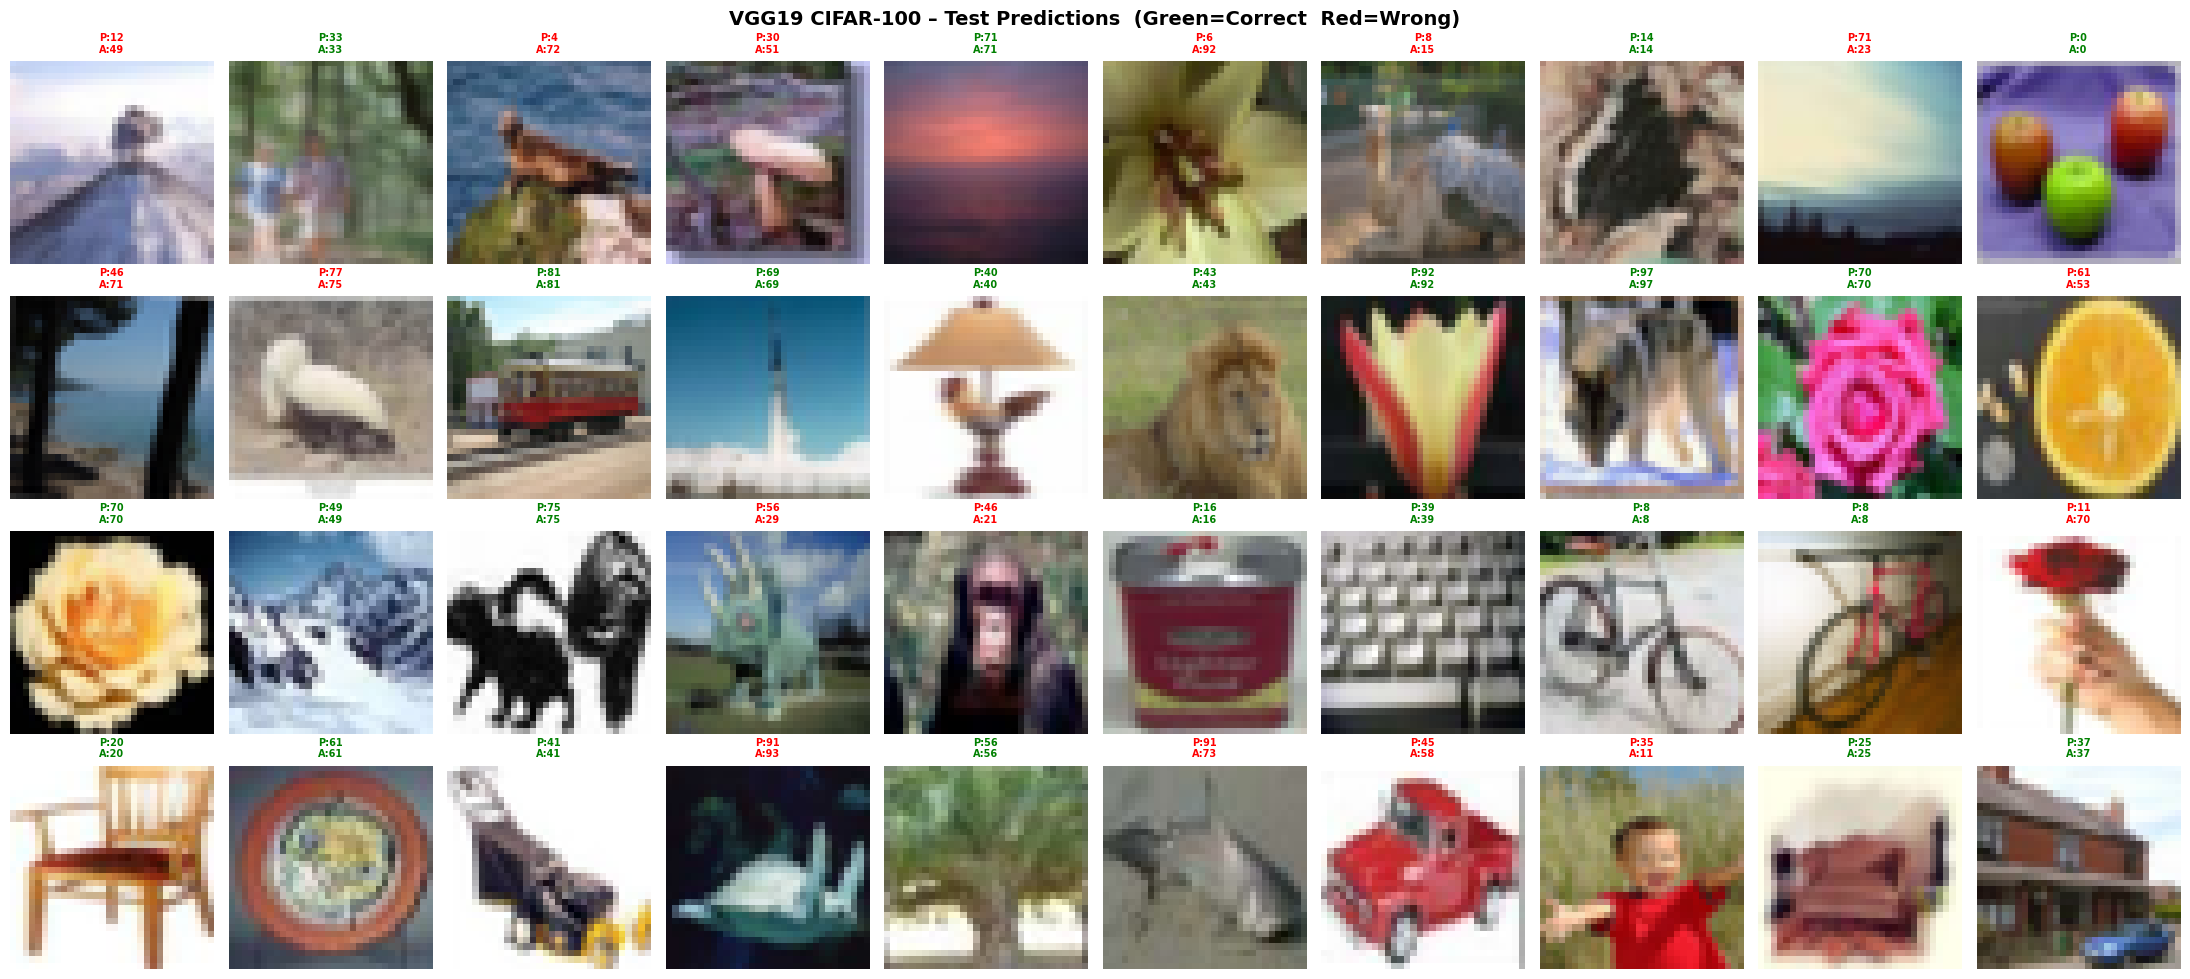

In [ ]:
# ── VGG19: Prediction grid ────────────────────────────────────────────────────
fig, axes = plt.subplots(4, 10, figsize=(22, 10))
axes = axes.ravel()
for i in range(40):
    axes[i].imshow(X_test_100[i])
    correct = y_pred_vgg19[i] == Y_test_100_flat[i]
    color = 'green' if correct else 'red'
    axes[i].set_title(f'P:{y_pred_vgg19[i]}\nA:{Y_test_100_flat[i]}',
                      fontsize=7, color=color, fontweight='bold')
    axes[i].axis('off')
plt.suptitle('VGG19 CIFAR-100 – Test Predictions  (Green=Correct  Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
vgg19_improved.save('vgg19_improved_cifar100.keras')
print('VGG19 improved model saved!')

# Verify load and predict
loaded_vgg19 = keras.models.load_model('vgg19_improved_cifar100.keras')
sample_preds = np.argmax(loaded_vgg19.predict(x_test100_proc[:5]), axis=1)
print('Loaded model predictions:', sample_preds)
print('Actual labels:           ', Y_test_100_flat[:5])

VGG19 improved model saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Loaded model predictions: [12 33  4 30 71]
Actual labels:            [49 33 72 51 71]


7: Overall Model Comparison

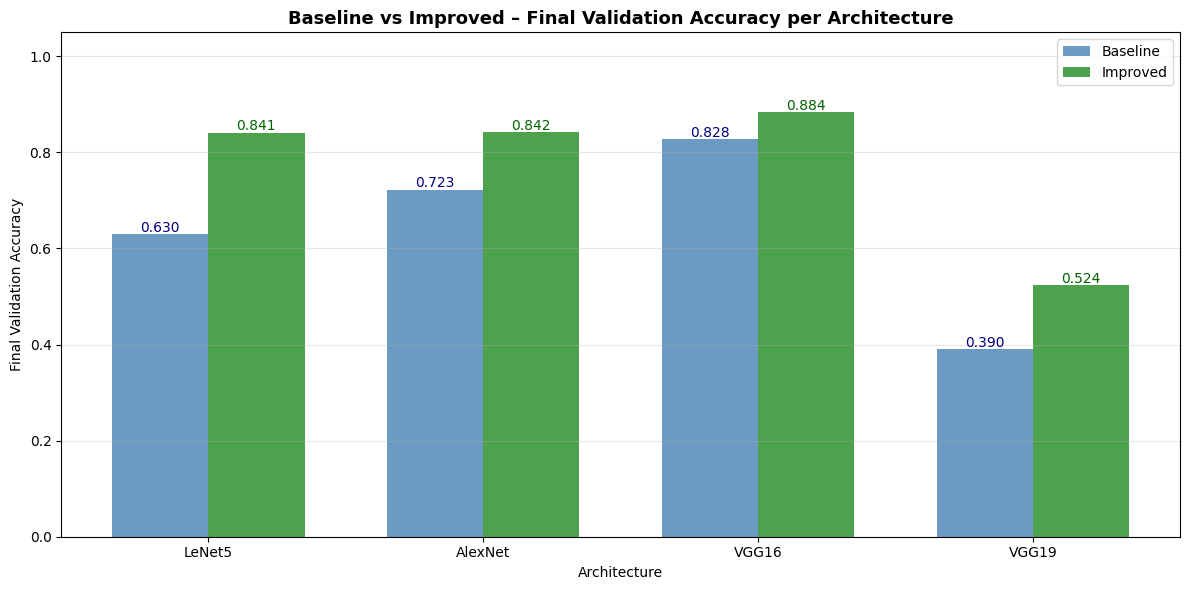

In [ ]:
# ── Val Accuracy Grouped Bar Chart ─────────────────────────────────────────────
arch_names   = ['LeNet5', 'AlexNet', 'VGG16', 'VGG19']

# Use LAST epoch val accuracy instead of max
baseline_acc = [hist_lenet.history['val_accuracy'][-1],
                hist_alex.history['val_accuracy'][-1],
                hist_vgg16.history['val_accuracy'][-1],
                hist_vgg19.history['val_accuracy'][-1]]

improved_acc = [hist_lenet_imp.history['val_accuracy'][-1],
                hist_alex_imp.history['val_accuracy'][-1],
                hist_vgg16_imp.history['val_accuracy'][-1],
                hist_vgg19_imp.history['val_accuracy'][-1]]

x = np.arange(len(arch_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, baseline_acc, width, label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, improved_acc, width, label='Improved', color='forestgreen', alpha=0.8)

ax.set_xlabel('Architecture'); ax.set_ylabel('Final Validation Accuracy')
ax.set_title('Baseline vs Improved – Final Validation Accuracy per Architecture', fontsize=13, fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels(arch_names)
ax.legend(); ax.grid(axis='y', alpha=0.3); ax.set_ylim(0, 1.05)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{bar.get_height():.3f}', ha='center', fontsize=10, color='navy')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{bar.get_height():.3f}', ha='center', fontsize=10, color='darkgreen')

plt.tight_layout()
plt.show()